In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "int95"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 135
Categorical features: 6
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 207
Categorical Columns: 6


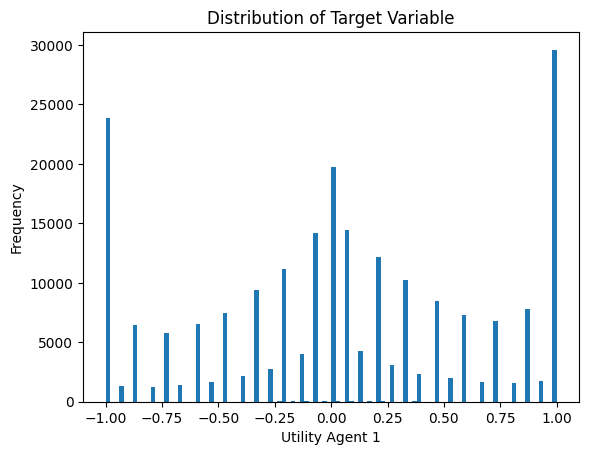

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.499759


[200]	valid_0's rmse: 0.479878


[300]	valid_0's rmse: 0.469301


[400]	valid_0's rmse: 0.462157


[500]	valid_0's rmse: 0.456456


[600]	valid_0's rmse: 0.452222


[700]	valid_0's rmse: 0.449197


[800]	valid_0's rmse: 0.446517


[900]	valid_0's rmse: 0.444142


[1000]	valid_0's rmse: 0.442383


[1100]	valid_0's rmse: 0.440978


[1200]	valid_0's rmse: 0.439625


[1300]	valid_0's rmse: 0.438507


[1400]	valid_0's rmse: 0.437458


[1500]	valid_0's rmse: 0.436635


[1600]	valid_0's rmse: 0.436071


[1700]	valid_0's rmse: 0.435459


[1800]	valid_0's rmse: 0.434837


[1900]	valid_0's rmse: 0.434213


[2000]	valid_0's rmse: 0.433814


[2100]	valid_0's rmse: 0.433456


[2200]	valid_0's rmse: 0.433006


[2300]	valid_0's rmse: 0.432674


[2400]	valid_0's rmse: 0.432523


[2500]	valid_0's rmse: 0.432157


[2600]	valid_0's rmse: 0.43192


[2700]	valid_0's rmse: 0.431576


[2800]	valid_0's rmse: 0.431408


[2900]	valid_0's rmse: 0.431263


[3000]	valid_0's rmse: 0.431011


[3100]	valid_0's rmse: 0.430724


[3200]	valid_0's rmse: 0.430395


[3300]	valid_0's rmse: 0.430129


[3400]	valid_0's rmse: 0.429951


[3500]	valid_0's rmse: 0.429768


[3600]	valid_0's rmse: 0.429589


[3700]	valid_0's rmse: 0.429388


[3800]	valid_0's rmse: 0.429271


[3900]	valid_0's rmse: 0.429181


[4000]	valid_0's rmse: 0.429138


[4100]	valid_0's rmse: 0.42905


[4200]	valid_0's rmse: 0.428921


[4300]	valid_0's rmse: 0.428818


[4400]	valid_0's rmse: 0.428755


[4500]	valid_0's rmse: 0.42866


[4600]	valid_0's rmse: 0.42854


[4700]	valid_0's rmse: 0.4284


[4800]	valid_0's rmse: 0.428253


[4900]	valid_0's rmse: 0.42822


[5000]	valid_0's rmse: 0.428096


[5100]	valid_0's rmse: 0.428042


[5200]	valid_0's rmse: 0.42801


[5300]	valid_0's rmse: 0.427888


[5400]	valid_0's rmse: 0.427807


[5500]	valid_0's rmse: 0.427862


[5600]	valid_0's rmse: 0.427824


[5700]	valid_0's rmse: 0.427805


[5800]	valid_0's rmse: 0.427747


[5900]	valid_0's rmse: 0.427706


[6000]	valid_0's rmse: 0.427661


[6100]	valid_0's rmse: 0.427585


[6200]	valid_0's rmse: 0.427407


[6300]	valid_0's rmse: 0.427307


[6400]	valid_0's rmse: 0.427229


[6500]	valid_0's rmse: 0.427216


[6600]	valid_0's rmse: 0.427193


[6700]	valid_0's rmse: 0.42721


[6800]	valid_0's rmse: 0.427139


[6900]	valid_0's rmse: 0.427104


[7000]	valid_0's rmse: 0.427109


[7100]	valid_0's rmse: 0.427126


[7200]	valid_0's rmse: 0.427134


[7300]	valid_0's rmse: 0.427142


[7400]	valid_0's rmse: 0.427104


[7500]	valid_0's rmse: 0.42707


[7600]	valid_0's rmse: 0.427036


[7700]	valid_0's rmse: 0.426955


[7800]	valid_0's rmse: 0.426929


[7900]	valid_0's rmse: 0.42691


[8000]	valid_0's rmse: 0.426859


[8100]	valid_0's rmse: 0.42688


[8200]	valid_0's rmse: 0.426895


[8300]	valid_0's rmse: 0.426858


[8400]	valid_0's rmse: 0.426867


[8500]	valid_0's rmse: 0.426847


[8600]	valid_0's rmse: 0.426841


[8700]	valid_0's rmse: 0.426827


[8800]	valid_0's rmse: 0.426846


[8900]	valid_0's rmse: 0.426852


[9000]	valid_0's rmse: 0.426858


[9100]	valid_0's rmse: 0.426851


[9200]	valid_0's rmse: 0.426826


[9300]	valid_0's rmse: 0.426867


[9400]	valid_0's rmse: 0.426795


[9500]	valid_0's rmse: 0.426799


[9600]	valid_0's rmse: 0.426787


[9700]	valid_0's rmse: 0.426796


[9800]	valid_0's rmse: 0.426814


[9900]	valid_0's rmse: 0.426745


[10000]	valid_0's rmse: 0.426799


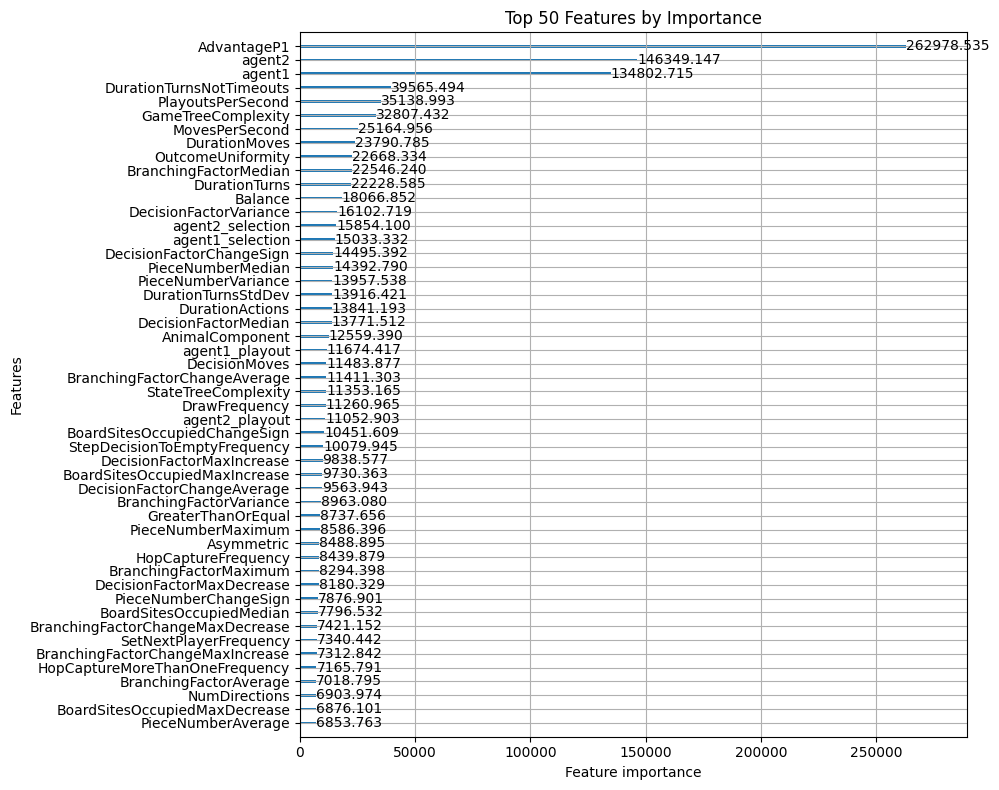

Fold 1 - RMSE: 0.42626463901283407
Fold 2


[100]	valid_0's rmse: 0.510085


[200]	valid_0's rmse: 0.493216


[300]	valid_0's rmse: 0.483063


[400]	valid_0's rmse: 0.476648


[500]	valid_0's rmse: 0.472067


[600]	valid_0's rmse: 0.468871


[700]	valid_0's rmse: 0.466282


[800]	valid_0's rmse: 0.464628


[900]	valid_0's rmse: 0.462968


[1000]	valid_0's rmse: 0.462075


[1100]	valid_0's rmse: 0.460974


[1200]	valid_0's rmse: 0.459923


[1300]	valid_0's rmse: 0.459022


[1400]	valid_0's rmse: 0.458466


[1500]	valid_0's rmse: 0.457778


[1600]	valid_0's rmse: 0.45718


[1700]	valid_0's rmse: 0.45691


[1800]	valid_0's rmse: 0.456501


[1900]	valid_0's rmse: 0.45599


[2000]	valid_0's rmse: 0.455557


[2100]	valid_0's rmse: 0.455223


[2200]	valid_0's rmse: 0.454924


[2300]	valid_0's rmse: 0.454584


[2400]	valid_0's rmse: 0.454323


[2500]	valid_0's rmse: 0.453895


[2600]	valid_0's rmse: 0.453651


[2700]	valid_0's rmse: 0.453401


[2800]	valid_0's rmse: 0.453107


[2900]	valid_0's rmse: 0.452812


[3000]	valid_0's rmse: 0.452712


[3100]	valid_0's rmse: 0.452532


[3200]	valid_0's rmse: 0.452268


[3300]	valid_0's rmse: 0.452071


[3400]	valid_0's rmse: 0.451846


[3500]	valid_0's rmse: 0.451632


[3600]	valid_0's rmse: 0.451509


[3700]	valid_0's rmse: 0.451447


[3800]	valid_0's rmse: 0.451372


[3900]	valid_0's rmse: 0.451274


[4000]	valid_0's rmse: 0.451127


[4100]	valid_0's rmse: 0.45099


[4200]	valid_0's rmse: 0.450906


[4300]	valid_0's rmse: 0.450788


[4400]	valid_0's rmse: 0.450682


[4500]	valid_0's rmse: 0.450556


[4600]	valid_0's rmse: 0.450515


[4700]	valid_0's rmse: 0.450401


[4800]	valid_0's rmse: 0.450351


[4900]	valid_0's rmse: 0.450274


[5000]	valid_0's rmse: 0.450215


[5100]	valid_0's rmse: 0.450144


[5200]	valid_0's rmse: 0.450033


[5300]	valid_0's rmse: 0.449922


[5400]	valid_0's rmse: 0.449916


[5500]	valid_0's rmse: 0.449752


[5600]	valid_0's rmse: 0.449561


[5700]	valid_0's rmse: 0.449504


[5800]	valid_0's rmse: 0.449376


[5900]	valid_0's rmse: 0.449297


[6000]	valid_0's rmse: 0.44917


[6100]	valid_0's rmse: 0.44923


[6200]	valid_0's rmse: 0.449187


[6300]	valid_0's rmse: 0.449052


[6400]	valid_0's rmse: 0.448969


[6500]	valid_0's rmse: 0.44893


[6600]	valid_0's rmse: 0.448901


[6700]	valid_0's rmse: 0.448814


[6800]	valid_0's rmse: 0.448778


[6900]	valid_0's rmse: 0.44876


[7000]	valid_0's rmse: 0.448724


[7100]	valid_0's rmse: 0.448603


[7200]	valid_0's rmse: 0.448595


[7300]	valid_0's rmse: 0.448602


[7400]	valid_0's rmse: 0.448656


[7500]	valid_0's rmse: 0.448704


[7600]	valid_0's rmse: 0.448719


[7700]	valid_0's rmse: 0.448735


[7800]	valid_0's rmse: 0.448666


[7900]	valid_0's rmse: 0.448651


[8000]	valid_0's rmse: 0.448552


[8100]	valid_0's rmse: 0.448536


[8200]	valid_0's rmse: 0.448529


[8300]	valid_0's rmse: 0.448492


[8400]	valid_0's rmse: 0.448411


[8500]	valid_0's rmse: 0.448453


[8600]	valid_0's rmse: 0.448523


[8700]	valid_0's rmse: 0.448542


[8800]	valid_0's rmse: 0.44854


[8900]	valid_0's rmse: 0.448504


[9000]	valid_0's rmse: 0.448478


[9100]	valid_0's rmse: 0.448418


[9200]	valid_0's rmse: 0.448335


[9300]	valid_0's rmse: 0.448333


[9400]	valid_0's rmse: 0.448235


[9500]	valid_0's rmse: 0.448236


[9600]	valid_0's rmse: 0.448244


[9700]	valid_0's rmse: 0.448268


[9800]	valid_0's rmse: 0.448301


[9900]	valid_0's rmse: 0.448243


[10000]	valid_0's rmse: 0.448241


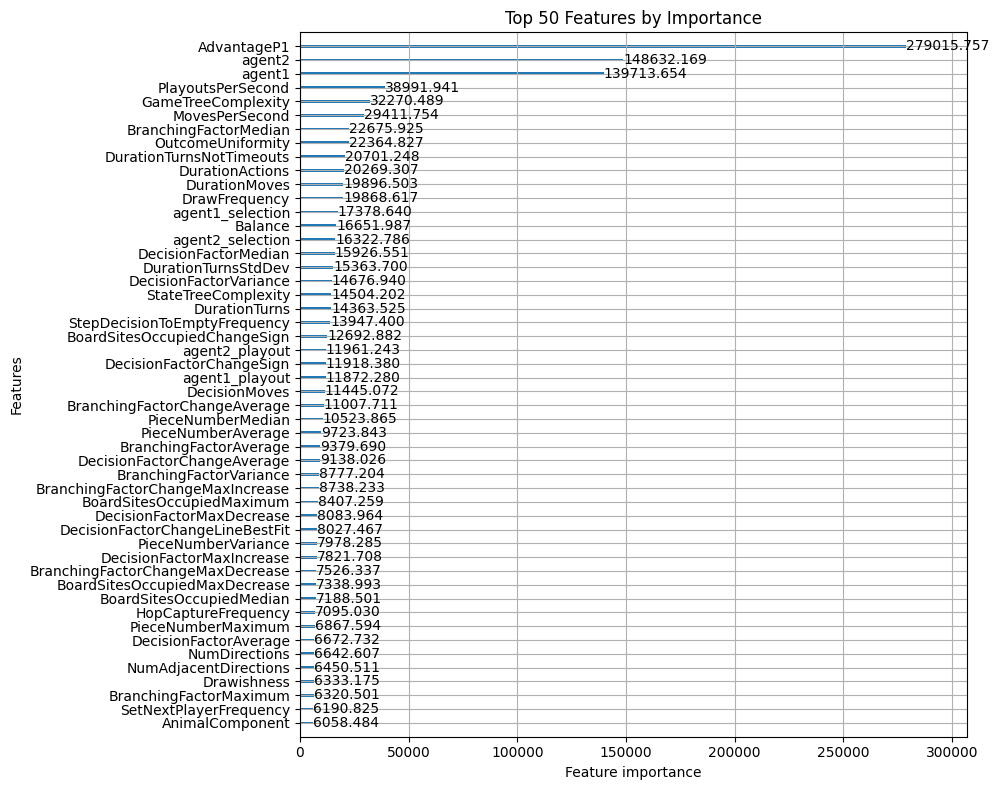

Fold 2 - RMSE: 0.4475399721080384
Fold 3


[100]	valid_0's rmse: 0.516042


[200]	valid_0's rmse: 0.48635


[300]	valid_0's rmse: 0.475462


[400]	valid_0's rmse: 0.467964


[500]	valid_0's rmse: 0.463583


[600]	valid_0's rmse: 0.460814


[700]	valid_0's rmse: 0.457963


[800]	valid_0's rmse: 0.455095


[900]	valid_0's rmse: 0.453033


[1000]	valid_0's rmse: 0.451831


[1100]	valid_0's rmse: 0.450471


[1200]	valid_0's rmse: 0.449387


[1300]	valid_0's rmse: 0.448269


[1400]	valid_0's rmse: 0.447369


[1500]	valid_0's rmse: 0.446627


[1600]	valid_0's rmse: 0.445876


[1700]	valid_0's rmse: 0.445317


[1800]	valid_0's rmse: 0.444894


[1900]	valid_0's rmse: 0.444524


[2000]	valid_0's rmse: 0.444229


[2100]	valid_0's rmse: 0.443441


[2200]	valid_0's rmse: 0.44289


[2300]	valid_0's rmse: 0.442531


[2400]	valid_0's rmse: 0.442231


[2500]	valid_0's rmse: 0.441935


[2600]	valid_0's rmse: 0.441628


[2700]	valid_0's rmse: 0.441435


[2800]	valid_0's rmse: 0.441174


[2900]	valid_0's rmse: 0.440872


[3000]	valid_0's rmse: 0.440717


[3100]	valid_0's rmse: 0.440543


[3200]	valid_0's rmse: 0.440362


[3300]	valid_0's rmse: 0.440018


[3400]	valid_0's rmse: 0.43988


[3500]	valid_0's rmse: 0.439684


[3600]	valid_0's rmse: 0.439496


[3700]	valid_0's rmse: 0.439329


[3800]	valid_0's rmse: 0.439153


[3900]	valid_0's rmse: 0.439102


[4000]	valid_0's rmse: 0.438979


[4100]	valid_0's rmse: 0.438837


[4200]	valid_0's rmse: 0.438717


[4300]	valid_0's rmse: 0.438695


[4400]	valid_0's rmse: 0.438527


[4500]	valid_0's rmse: 0.438402


[4600]	valid_0's rmse: 0.438351


[4700]	valid_0's rmse: 0.438304


[4800]	valid_0's rmse: 0.43824


[4900]	valid_0's rmse: 0.438134


[5000]	valid_0's rmse: 0.43812


[5100]	valid_0's rmse: 0.438086


[5200]	valid_0's rmse: 0.437965


[5300]	valid_0's rmse: 0.437899


[5400]	valid_0's rmse: 0.437853


[5500]	valid_0's rmse: 0.437788


[5600]	valid_0's rmse: 0.437803


[5700]	valid_0's rmse: 0.437769


[5800]	valid_0's rmse: 0.437645


[5900]	valid_0's rmse: 0.437566


[6000]	valid_0's rmse: 0.437544


[6100]	valid_0's rmse: 0.437537


[6200]	valid_0's rmse: 0.43745


[6300]	valid_0's rmse: 0.437427


[6400]	valid_0's rmse: 0.437373


[6500]	valid_0's rmse: 0.437355


[6600]	valid_0's rmse: 0.437329


[6700]	valid_0's rmse: 0.437336


[6800]	valid_0's rmse: 0.437171


[6900]	valid_0's rmse: 0.437164


[7000]	valid_0's rmse: 0.437097


[7100]	valid_0's rmse: 0.437079


[7200]	valid_0's rmse: 0.437035


[7300]	valid_0's rmse: 0.437018


[7400]	valid_0's rmse: 0.437009


[7500]	valid_0's rmse: 0.436993


[7600]	valid_0's rmse: 0.437008


[7700]	valid_0's rmse: 0.436897


[7800]	valid_0's rmse: 0.436838


[7900]	valid_0's rmse: 0.436823


[8000]	valid_0's rmse: 0.436709


[8100]	valid_0's rmse: 0.436658


[8200]	valid_0's rmse: 0.436582


[8300]	valid_0's rmse: 0.436567


[8400]	valid_0's rmse: 0.436567


[8500]	valid_0's rmse: 0.436584


[8600]	valid_0's rmse: 0.436596


[8700]	valid_0's rmse: 0.436546


[8800]	valid_0's rmse: 0.436589


[8900]	valid_0's rmse: 0.436592


[9000]	valid_0's rmse: 0.436607


[9100]	valid_0's rmse: 0.436545


[9200]	valid_0's rmse: 0.436536


[9300]	valid_0's rmse: 0.436515


[9400]	valid_0's rmse: 0.436467


[9500]	valid_0's rmse: 0.436449


[9600]	valid_0's rmse: 0.436414


[9700]	valid_0's rmse: 0.436344


[9800]	valid_0's rmse: 0.436377


[9900]	valid_0's rmse: 0.436385


[10000]	valid_0's rmse: 0.436288


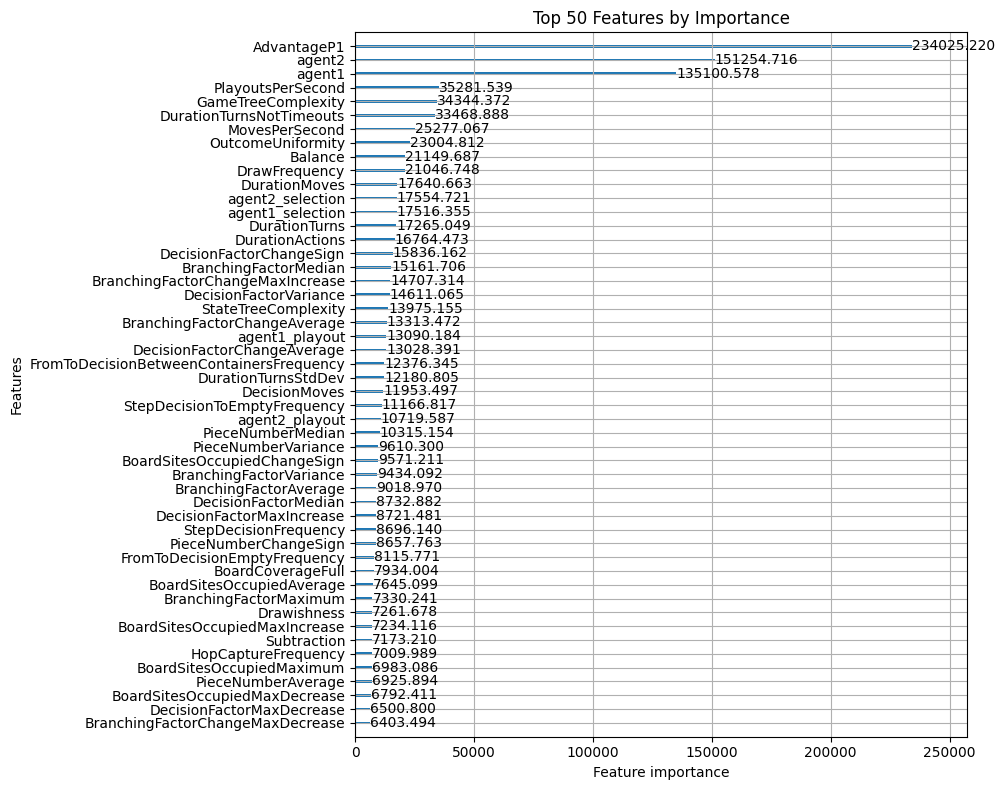

Fold 3 - RMSE: 0.43546889779399534
Fold 4


[100]	valid_0's rmse: 0.517043


[200]	valid_0's rmse: 0.491266


[300]	valid_0's rmse: 0.479187


[400]	valid_0's rmse: 0.469712


[500]	valid_0's rmse: 0.464192


[600]	valid_0's rmse: 0.459768


[700]	valid_0's rmse: 0.456816


[800]	valid_0's rmse: 0.454833


[900]	valid_0's rmse: 0.452942


[1000]	valid_0's rmse: 0.451347


[1100]	valid_0's rmse: 0.449782


[1200]	valid_0's rmse: 0.44858


[1300]	valid_0's rmse: 0.44754


[1400]	valid_0's rmse: 0.446589


[1500]	valid_0's rmse: 0.445799


[1600]	valid_0's rmse: 0.445061


[1700]	valid_0's rmse: 0.444569


[1800]	valid_0's rmse: 0.444023


[1900]	valid_0's rmse: 0.443408


[2000]	valid_0's rmse: 0.442901


[2100]	valid_0's rmse: 0.442431


[2200]	valid_0's rmse: 0.442057


[2300]	valid_0's rmse: 0.441644


[2400]	valid_0's rmse: 0.441311


[2500]	valid_0's rmse: 0.4411


[2600]	valid_0's rmse: 0.440827


[2700]	valid_0's rmse: 0.440383


[2800]	valid_0's rmse: 0.440033


[2900]	valid_0's rmse: 0.439775


[3000]	valid_0's rmse: 0.439653


[3100]	valid_0's rmse: 0.439326


[3200]	valid_0's rmse: 0.439041


[3300]	valid_0's rmse: 0.438826


[3400]	valid_0's rmse: 0.4386


[3500]	valid_0's rmse: 0.438287


[3600]	valid_0's rmse: 0.438075


[3700]	valid_0's rmse: 0.437929


[3800]	valid_0's rmse: 0.437796


[3900]	valid_0's rmse: 0.437649


[4000]	valid_0's rmse: 0.437513


[4100]	valid_0's rmse: 0.4373


[4200]	valid_0's rmse: 0.437224


[4300]	valid_0's rmse: 0.437104


[4400]	valid_0's rmse: 0.436998


[4500]	valid_0's rmse: 0.436898


[4600]	valid_0's rmse: 0.436764


[4700]	valid_0's rmse: 0.436634


[4800]	valid_0's rmse: 0.436519


[4900]	valid_0's rmse: 0.436397


[5000]	valid_0's rmse: 0.436305


[5100]	valid_0's rmse: 0.436217


[5200]	valid_0's rmse: 0.436166


[5300]	valid_0's rmse: 0.436075


[5400]	valid_0's rmse: 0.435977


[5500]	valid_0's rmse: 0.435922


[5600]	valid_0's rmse: 0.435829


[5700]	valid_0's rmse: 0.435764


[5800]	valid_0's rmse: 0.435696


[5900]	valid_0's rmse: 0.43566


[6000]	valid_0's rmse: 0.435637


[6100]	valid_0's rmse: 0.435616


[6200]	valid_0's rmse: 0.435556


[6300]	valid_0's rmse: 0.435465


[6400]	valid_0's rmse: 0.43542


[6500]	valid_0's rmse: 0.435374


[6600]	valid_0's rmse: 0.435311


[6700]	valid_0's rmse: 0.43523


[6800]	valid_0's rmse: 0.435202


[6900]	valid_0's rmse: 0.435221


[7000]	valid_0's rmse: 0.435201


[7100]	valid_0's rmse: 0.435134


[7200]	valid_0's rmse: 0.4351


[7300]	valid_0's rmse: 0.435037


[7400]	valid_0's rmse: 0.434992


[7500]	valid_0's rmse: 0.434939


[7600]	valid_0's rmse: 0.434943


[7700]	valid_0's rmse: 0.434905


[7800]	valid_0's rmse: 0.434931


[7900]	valid_0's rmse: 0.434883


[8000]	valid_0's rmse: 0.434919


[8100]	valid_0's rmse: 0.434862


[8200]	valid_0's rmse: 0.434857


[8300]	valid_0's rmse: 0.434822


[8400]	valid_0's rmse: 0.434779


[8500]	valid_0's rmse: 0.434726


[8600]	valid_0's rmse: 0.434737


[8700]	valid_0's rmse: 0.434748


[8800]	valid_0's rmse: 0.434722


[8900]	valid_0's rmse: 0.434705


[9000]	valid_0's rmse: 0.434641


[9100]	valid_0's rmse: 0.434606


[9200]	valid_0's rmse: 0.434605


[9300]	valid_0's rmse: 0.434566


[9400]	valid_0's rmse: 0.434572


[9500]	valid_0's rmse: 0.434492


[9600]	valid_0's rmse: 0.434491


[9700]	valid_0's rmse: 0.434504


[9800]	valid_0's rmse: 0.434522


[9900]	valid_0's rmse: 0.434494


[10000]	valid_0's rmse: 0.434459


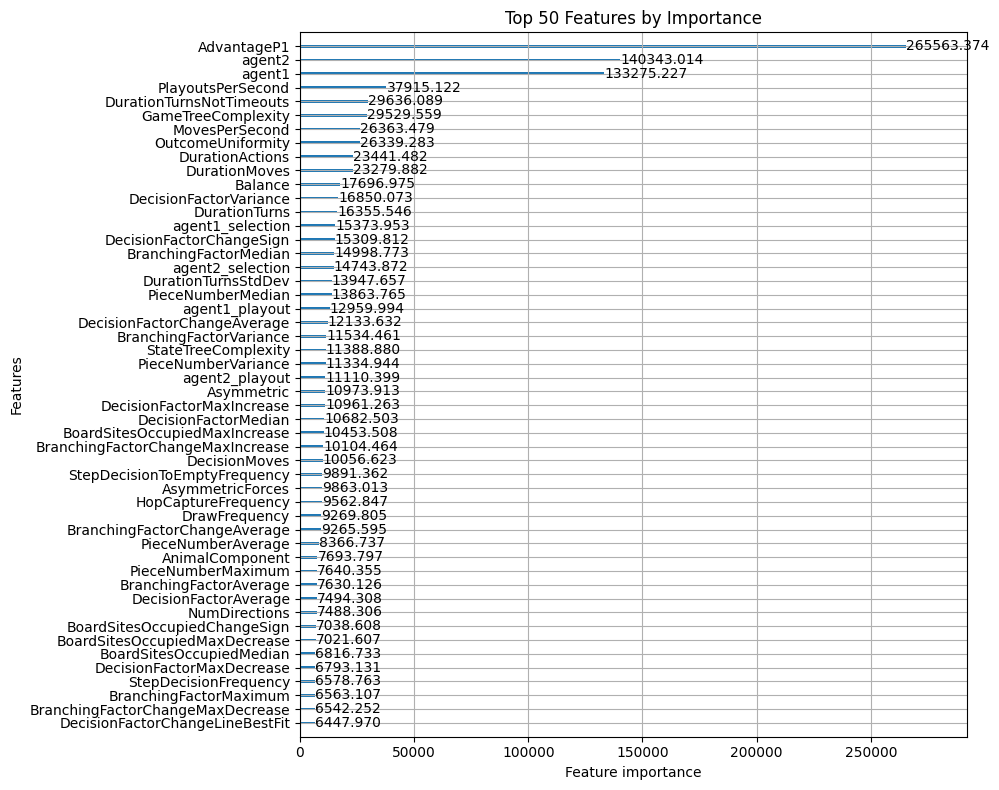

Fold 4 - RMSE: 0.4335521069303483
Fold 5


[100]	valid_0's rmse: 0.489697


[200]	valid_0's rmse: 0.467724


[300]	valid_0's rmse: 0.454621


[400]	valid_0's rmse: 0.444999


[500]	valid_0's rmse: 0.438591


[600]	valid_0's rmse: 0.433402


[700]	valid_0's rmse: 0.429881


[800]	valid_0's rmse: 0.427305


[900]	valid_0's rmse: 0.42517


[1000]	valid_0's rmse: 0.423172


[1100]	valid_0's rmse: 0.42162


[1200]	valid_0's rmse: 0.419893


[1300]	valid_0's rmse: 0.418643


[1400]	valid_0's rmse: 0.417558


[1500]	valid_0's rmse: 0.416771


[1600]	valid_0's rmse: 0.415983


[1700]	valid_0's rmse: 0.415271


[1800]	valid_0's rmse: 0.414677


[1900]	valid_0's rmse: 0.413923


[2000]	valid_0's rmse: 0.413373


[2100]	valid_0's rmse: 0.413051


[2200]	valid_0's rmse: 0.412591


[2300]	valid_0's rmse: 0.412025


[2400]	valid_0's rmse: 0.411569


[2500]	valid_0's rmse: 0.411219


[2600]	valid_0's rmse: 0.410932


[2700]	valid_0's rmse: 0.410685


[2800]	valid_0's rmse: 0.410321


[2900]	valid_0's rmse: 0.410019


[3000]	valid_0's rmse: 0.409833


[3100]	valid_0's rmse: 0.40953


[3200]	valid_0's rmse: 0.409301


[3300]	valid_0's rmse: 0.409096


[3400]	valid_0's rmse: 0.408977


[3500]	valid_0's rmse: 0.408734


[3600]	valid_0's rmse: 0.408656


[3700]	valid_0's rmse: 0.408444


[3800]	valid_0's rmse: 0.408343


[3900]	valid_0's rmse: 0.408265


[4000]	valid_0's rmse: 0.40809


[4100]	valid_0's rmse: 0.407974


[4200]	valid_0's rmse: 0.407694


[4300]	valid_0's rmse: 0.407593


[4400]	valid_0's rmse: 0.407438


[4500]	valid_0's rmse: 0.407271


[4600]	valid_0's rmse: 0.407218


[4700]	valid_0's rmse: 0.40713


[4800]	valid_0's rmse: 0.40701


[4900]	valid_0's rmse: 0.406836


[5000]	valid_0's rmse: 0.406728


[5100]	valid_0's rmse: 0.406682


[5200]	valid_0's rmse: 0.406606


[5300]	valid_0's rmse: 0.406575


[5400]	valid_0's rmse: 0.40652


[5500]	valid_0's rmse: 0.406485


[5600]	valid_0's rmse: 0.406434


[5700]	valid_0's rmse: 0.406365


[5800]	valid_0's rmse: 0.406335


[5900]	valid_0's rmse: 0.406329


[6000]	valid_0's rmse: 0.406183


[6100]	valid_0's rmse: 0.40616


[6200]	valid_0's rmse: 0.406075


[6300]	valid_0's rmse: 0.406015


[6400]	valid_0's rmse: 0.40599


[6500]	valid_0's rmse: 0.405909


[6600]	valid_0's rmse: 0.405835


[6700]	valid_0's rmse: 0.405852


[6800]	valid_0's rmse: 0.4058


[6900]	valid_0's rmse: 0.405791


[7000]	valid_0's rmse: 0.40568


[7100]	valid_0's rmse: 0.40565


[7200]	valid_0's rmse: 0.405632


[7300]	valid_0's rmse: 0.405581


[7400]	valid_0's rmse: 0.405565


[7500]	valid_0's rmse: 0.405494


[7600]	valid_0's rmse: 0.405479


[7700]	valid_0's rmse: 0.405485


[7800]	valid_0's rmse: 0.405453


[7900]	valid_0's rmse: 0.405434


[8000]	valid_0's rmse: 0.405424


[8100]	valid_0's rmse: 0.405406


[8200]	valid_0's rmse: 0.405376


[8300]	valid_0's rmse: 0.405312


[8400]	valid_0's rmse: 0.405274


[8500]	valid_0's rmse: 0.405218


[8600]	valid_0's rmse: 0.405253


[8700]	valid_0's rmse: 0.405253


[8800]	valid_0's rmse: 0.405265


[8900]	valid_0's rmse: 0.405279


[9000]	valid_0's rmse: 0.405298


[9100]	valid_0's rmse: 0.405214


[9200]	valid_0's rmse: 0.405138


[9300]	valid_0's rmse: 0.405108


[9400]	valid_0's rmse: 0.405061


[9500]	valid_0's rmse: 0.405039


[9600]	valid_0's rmse: 0.405051


[9700]	valid_0's rmse: 0.405052


[9800]	valid_0's rmse: 0.405033


[9900]	valid_0's rmse: 0.405028


[10000]	valid_0's rmse: 0.404997


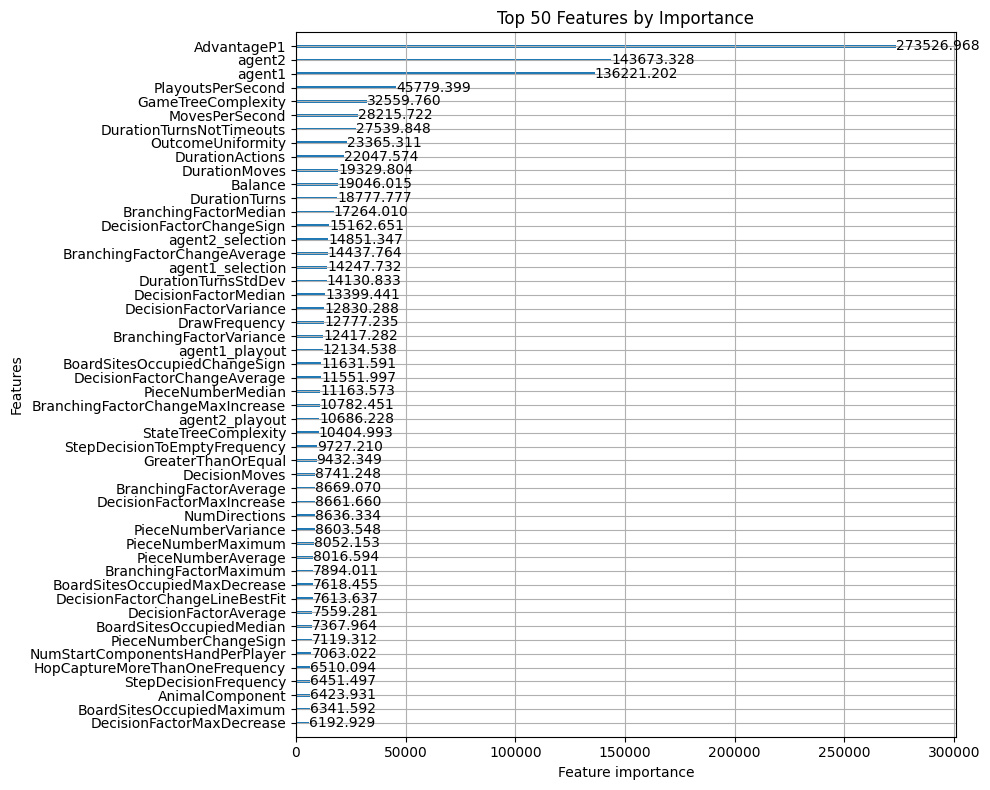

Fold 5 - RMSE: 0.40453014033581897
List of oof scores: [0.42626463901283407, 0.4475399721080384, 0.43546889779399534, 0.4335521069303483, 0.40453014033581897]
Average oof score: 0.42947115123620694


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.478138


[200]	valid_0's rmse: 0.457564


[300]	valid_0's rmse: 0.446312


[400]	valid_0's rmse: 0.439238


[500]	valid_0's rmse: 0.434331


[600]	valid_0's rmse: 0.430756


[700]	valid_0's rmse: 0.428469


[800]	valid_0's rmse: 0.426975


[900]	valid_0's rmse: 0.425486


[1000]	valid_0's rmse: 0.424093


[1100]	valid_0's rmse: 0.42298


[1200]	valid_0's rmse: 0.422015


[1300]	valid_0's rmse: 0.42122


[1400]	valid_0's rmse: 0.420457


[1500]	valid_0's rmse: 0.419791


[1600]	valid_0's rmse: 0.419391


[1700]	valid_0's rmse: 0.418861


[1800]	valid_0's rmse: 0.418443


[1900]	valid_0's rmse: 0.417814


[2000]	valid_0's rmse: 0.417366


[2100]	valid_0's rmse: 0.417022


[2200]	valid_0's rmse: 0.416767


[2300]	valid_0's rmse: 0.416405


[2400]	valid_0's rmse: 0.416186


[2500]	valid_0's rmse: 0.415882


[2600]	valid_0's rmse: 0.415653


[2700]	valid_0's rmse: 0.41534


[2800]	valid_0's rmse: 0.415091


[2900]	valid_0's rmse: 0.414847


[3000]	valid_0's rmse: 0.414544


[3100]	valid_0's rmse: 0.41432


[3200]	valid_0's rmse: 0.414105


[3300]	valid_0's rmse: 0.413839


[3400]	valid_0's rmse: 0.413617


[3500]	valid_0's rmse: 0.413528


[3600]	valid_0's rmse: 0.413424


[3700]	valid_0's rmse: 0.413166


[3800]	valid_0's rmse: 0.413066


[3900]	valid_0's rmse: 0.412892


[4000]	valid_0's rmse: 0.412746


[4100]	valid_0's rmse: 0.412605


[4200]	valid_0's rmse: 0.412472


[4300]	valid_0's rmse: 0.412374


[4400]	valid_0's rmse: 0.41214


[4500]	valid_0's rmse: 0.412056


[4600]	valid_0's rmse: 0.411976


[4700]	valid_0's rmse: 0.411842


[4800]	valid_0's rmse: 0.411691


[4900]	valid_0's rmse: 0.411608


[5000]	valid_0's rmse: 0.411583


[5100]	valid_0's rmse: 0.411501


[5200]	valid_0's rmse: 0.411449


[5300]	valid_0's rmse: 0.411377


[5400]	valid_0's rmse: 0.41126


[5500]	valid_0's rmse: 0.411219


[5600]	valid_0's rmse: 0.411022


[5700]	valid_0's rmse: 0.410935


[5800]	valid_0's rmse: 0.410849


[5900]	valid_0's rmse: 0.410803


[6000]	valid_0's rmse: 0.410737


[6100]	valid_0's rmse: 0.410718


[6200]	valid_0's rmse: 0.410711


[6300]	valid_0's rmse: 0.410705


[6400]	valid_0's rmse: 0.41067


[6500]	valid_0's rmse: 0.410627


[6600]	valid_0's rmse: 0.410561


[6700]	valid_0's rmse: 0.410517


[6800]	valid_0's rmse: 0.410484


[6900]	valid_0's rmse: 0.410486


[7000]	valid_0's rmse: 0.410462


[7100]	valid_0's rmse: 0.410435


[7200]	valid_0's rmse: 0.410401


[7300]	valid_0's rmse: 0.410371


[7400]	valid_0's rmse: 0.410369


[7500]	valid_0's rmse: 0.410324


[7600]	valid_0's rmse: 0.410296


[7700]	valid_0's rmse: 0.410285


[7800]	valid_0's rmse: 0.410283


[7900]	valid_0's rmse: 0.410232


[8000]	valid_0's rmse: 0.410163


[8100]	valid_0's rmse: 0.410122


[8200]	valid_0's rmse: 0.410059


[8300]	valid_0's rmse: 0.410036


[8400]	valid_0's rmse: 0.409953


[8500]	valid_0's rmse: 0.40989


[8600]	valid_0's rmse: 0.40975


[8700]	valid_0's rmse: 0.409655


[8800]	valid_0's rmse: 0.409623


[8900]	valid_0's rmse: 0.409598


[9000]	valid_0's rmse: 0.409608


[9100]	valid_0's rmse: 0.409591


[9200]	valid_0's rmse: 0.409551


[9300]	valid_0's rmse: 0.409565


[9400]	valid_0's rmse: 0.40957


[9500]	valid_0's rmse: 0.409594


[9600]	valid_0's rmse: 0.409576


[9700]	valid_0's rmse: 0.409548


[9800]	valid_0's rmse: 0.409501


[9900]	valid_0's rmse: 0.409498


[10000]	valid_0's rmse: 0.409432


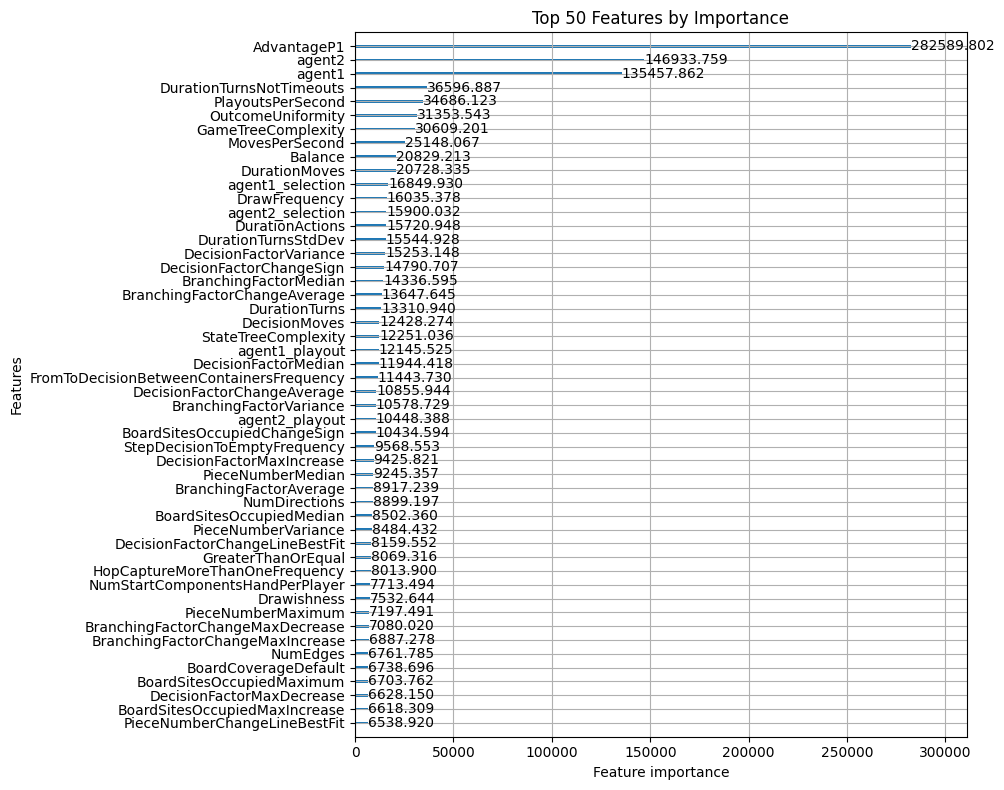

Fold 1 - RMSE: 0.4089583230307966
Fold 2


[100]	valid_0's rmse: 0.46546


[200]	valid_0's rmse: 0.443296


[300]	valid_0's rmse: 0.433995


[400]	valid_0's rmse: 0.427745


[500]	valid_0's rmse: 0.423974


[600]	valid_0's rmse: 0.421236


[700]	valid_0's rmse: 0.419026


[800]	valid_0's rmse: 0.416973


[900]	valid_0's rmse: 0.415357


[1000]	valid_0's rmse: 0.414346


[1100]	valid_0's rmse: 0.413323


[1200]	valid_0's rmse: 0.412442


[1300]	valid_0's rmse: 0.411668


[1400]	valid_0's rmse: 0.411208


[1500]	valid_0's rmse: 0.410809


[1600]	valid_0's rmse: 0.410362


[1700]	valid_0's rmse: 0.410083


[1800]	valid_0's rmse: 0.409728


[1900]	valid_0's rmse: 0.409338


[2000]	valid_0's rmse: 0.408807


[2100]	valid_0's rmse: 0.408486


[2200]	valid_0's rmse: 0.408131


[2300]	valid_0's rmse: 0.407821


[2400]	valid_0's rmse: 0.407564


[2500]	valid_0's rmse: 0.407284


[2600]	valid_0's rmse: 0.407112


[2700]	valid_0's rmse: 0.407037


[2800]	valid_0's rmse: 0.406801


[2900]	valid_0's rmse: 0.406598


[3000]	valid_0's rmse: 0.406438


[3100]	valid_0's rmse: 0.406221


[3200]	valid_0's rmse: 0.406144


[3300]	valid_0's rmse: 0.405983


[3400]	valid_0's rmse: 0.40581


[3500]	valid_0's rmse: 0.405782


[3600]	valid_0's rmse: 0.405714


[3700]	valid_0's rmse: 0.405658


[3800]	valid_0's rmse: 0.405579


[3900]	valid_0's rmse: 0.405558


[4000]	valid_0's rmse: 0.405532


[4100]	valid_0's rmse: 0.405403


[4200]	valid_0's rmse: 0.405394


[4300]	valid_0's rmse: 0.40532


[4400]	valid_0's rmse: 0.40532


[4500]	valid_0's rmse: 0.405337


[4600]	valid_0's rmse: 0.405317


[4700]	valid_0's rmse: 0.405364


[4800]	valid_0's rmse: 0.405299


[4900]	valid_0's rmse: 0.405232


[5000]	valid_0's rmse: 0.405161


[5100]	valid_0's rmse: 0.405136


[5200]	valid_0's rmse: 0.40512


[5300]	valid_0's rmse: 0.405084


[5400]	valid_0's rmse: 0.405053


[5500]	valid_0's rmse: 0.404986


[5600]	valid_0's rmse: 0.40504


[5700]	valid_0's rmse: 0.404975


[5800]	valid_0's rmse: 0.404922


[5900]	valid_0's rmse: 0.404841


[6000]	valid_0's rmse: 0.404816


[6100]	valid_0's rmse: 0.404725


[6200]	valid_0's rmse: 0.404686


[6300]	valid_0's rmse: 0.404693


[6400]	valid_0's rmse: 0.404702


[6500]	valid_0's rmse: 0.404627


[6600]	valid_0's rmse: 0.404621


[6700]	valid_0's rmse: 0.404592


[6800]	valid_0's rmse: 0.404612


[6900]	valid_0's rmse: 0.404643


[7000]	valid_0's rmse: 0.404601


[7100]	valid_0's rmse: 0.404549


[7200]	valid_0's rmse: 0.404567


[7300]	valid_0's rmse: 0.404485


[7400]	valid_0's rmse: 0.404486


[7500]	valid_0's rmse: 0.40449


[7600]	valid_0's rmse: 0.404481


[7700]	valid_0's rmse: 0.404513


[7800]	valid_0's rmse: 0.404554


[7900]	valid_0's rmse: 0.404528


[8000]	valid_0's rmse: 0.404565


[8100]	valid_0's rmse: 0.40469


[8200]	valid_0's rmse: 0.40472


[8300]	valid_0's rmse: 0.404793


[8400]	valid_0's rmse: 0.404824


[8500]	valid_0's rmse: 0.404819


[8600]	valid_0's rmse: 0.404831


[8700]	valid_0's rmse: 0.40488


[8800]	valid_0's rmse: 0.404839


[8900]	valid_0's rmse: 0.404823


[9000]	valid_0's rmse: 0.40483


[9100]	valid_0's rmse: 0.40482


[9200]	valid_0's rmse: 0.404837


[9300]	valid_0's rmse: 0.404868


[9400]	valid_0's rmse: 0.404847


[9500]	valid_0's rmse: 0.404874


[9600]	valid_0's rmse: 0.404858


[9700]	valid_0's rmse: 0.404887


[9800]	valid_0's rmse: 0.404871


[9900]	valid_0's rmse: 0.404873


[10000]	valid_0's rmse: 0.404848


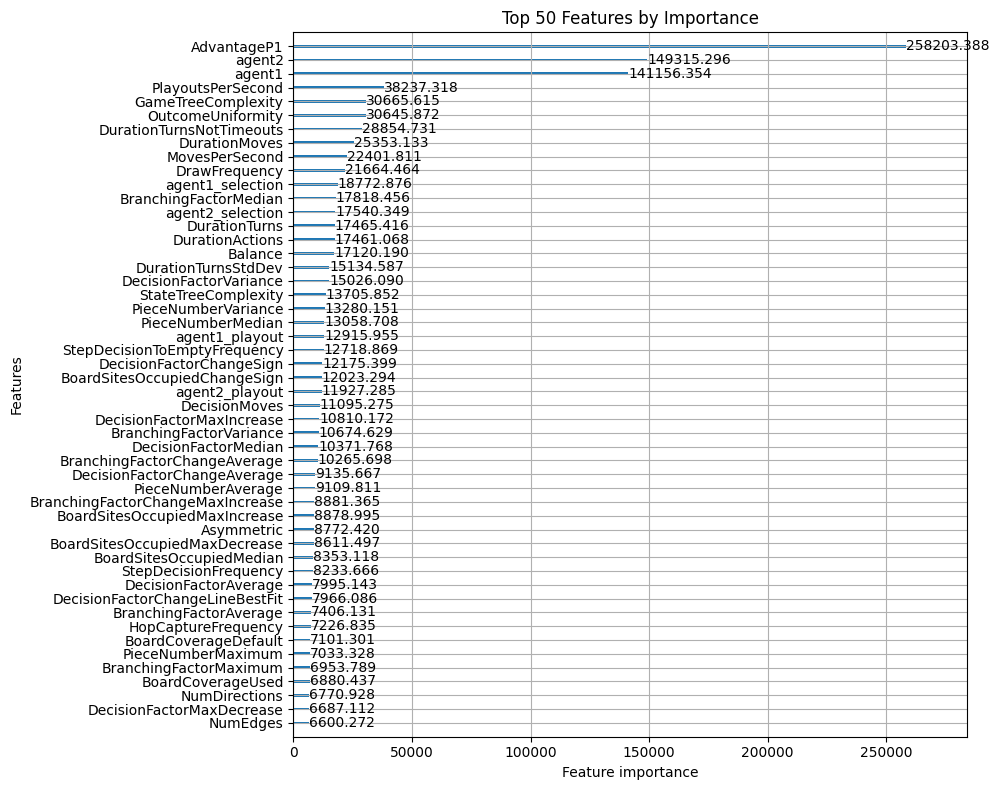

Fold 2 - RMSE: 0.40424631600616534
Fold 3


[100]	valid_0's rmse: 0.530407


[200]	valid_0's rmse: 0.503141


[300]	valid_0's rmse: 0.488669


[400]	valid_0's rmse: 0.47899


[500]	valid_0's rmse: 0.471714


[600]	valid_0's rmse: 0.466451


[700]	valid_0's rmse: 0.461747


[800]	valid_0's rmse: 0.458397


[900]	valid_0's rmse: 0.456356


[1000]	valid_0's rmse: 0.454411


[1100]	valid_0's rmse: 0.452585


[1200]	valid_0's rmse: 0.451092


[1300]	valid_0's rmse: 0.450002


[1400]	valid_0's rmse: 0.44898


[1500]	valid_0's rmse: 0.44808


[1600]	valid_0's rmse: 0.447253


[1700]	valid_0's rmse: 0.446369


[1800]	valid_0's rmse: 0.445933


[1900]	valid_0's rmse: 0.445259


[2000]	valid_0's rmse: 0.444751


[2100]	valid_0's rmse: 0.444106


[2200]	valid_0's rmse: 0.443579


[2300]	valid_0's rmse: 0.443028


[2400]	valid_0's rmse: 0.442522


[2500]	valid_0's rmse: 0.442228


[2600]	valid_0's rmse: 0.441886


[2700]	valid_0's rmse: 0.44157


[2800]	valid_0's rmse: 0.441306


[2900]	valid_0's rmse: 0.44108


[3000]	valid_0's rmse: 0.44078


[3100]	valid_0's rmse: 0.440561


[3200]	valid_0's rmse: 0.440335


[3300]	valid_0's rmse: 0.440155


[3400]	valid_0's rmse: 0.439902


[3500]	valid_0's rmse: 0.439649


[3600]	valid_0's rmse: 0.43941


[3700]	valid_0's rmse: 0.439238


[3800]	valid_0's rmse: 0.439063


[3900]	valid_0's rmse: 0.438832


[4000]	valid_0's rmse: 0.438665


[4100]	valid_0's rmse: 0.438513


[4200]	valid_0's rmse: 0.43823


[4300]	valid_0's rmse: 0.437984


[4400]	valid_0's rmse: 0.437835


[4500]	valid_0's rmse: 0.43775


[4600]	valid_0's rmse: 0.43761


[4700]	valid_0's rmse: 0.437546


[4800]	valid_0's rmse: 0.437449


[4900]	valid_0's rmse: 0.437337


[5000]	valid_0's rmse: 0.437175


[5100]	valid_0's rmse: 0.437057


[5200]	valid_0's rmse: 0.436956


[5300]	valid_0's rmse: 0.436786


[5400]	valid_0's rmse: 0.436649


[5500]	valid_0's rmse: 0.43648


[5600]	valid_0's rmse: 0.436444


[5700]	valid_0's rmse: 0.436339


[5800]	valid_0's rmse: 0.436316


[5900]	valid_0's rmse: 0.436247


[6000]	valid_0's rmse: 0.436179


[6100]	valid_0's rmse: 0.436069


[6200]	valid_0's rmse: 0.435912


[6300]	valid_0's rmse: 0.435845


[6400]	valid_0's rmse: 0.435831


[6500]	valid_0's rmse: 0.435743


[6600]	valid_0's rmse: 0.43569


[6700]	valid_0's rmse: 0.435598


[6800]	valid_0's rmse: 0.435467


[6900]	valid_0's rmse: 0.435479


[7000]	valid_0's rmse: 0.435442


[7100]	valid_0's rmse: 0.435403


[7200]	valid_0's rmse: 0.435271


[7300]	valid_0's rmse: 0.435255


[7400]	valid_0's rmse: 0.435151


[7500]	valid_0's rmse: 0.435145


[7600]	valid_0's rmse: 0.435118


[7700]	valid_0's rmse: 0.435078


[7800]	valid_0's rmse: 0.435033


[7900]	valid_0's rmse: 0.434988


[8000]	valid_0's rmse: 0.434895


[8100]	valid_0's rmse: 0.434759


[8200]	valid_0's rmse: 0.434713


[8300]	valid_0's rmse: 0.434685


[8400]	valid_0's rmse: 0.434635


[8500]	valid_0's rmse: 0.434647


[8600]	valid_0's rmse: 0.434668


[8700]	valid_0's rmse: 0.434631


[8800]	valid_0's rmse: 0.434644


[8900]	valid_0's rmse: 0.434562


[9000]	valid_0's rmse: 0.434541


[9100]	valid_0's rmse: 0.434506


[9200]	valid_0's rmse: 0.434453


[9300]	valid_0's rmse: 0.434454


[9400]	valid_0's rmse: 0.434411


[9500]	valid_0's rmse: 0.434354


[9600]	valid_0's rmse: 0.434256


[9700]	valid_0's rmse: 0.43427


[9800]	valid_0's rmse: 0.434271


[9900]	valid_0's rmse: 0.434235


[10000]	valid_0's rmse: 0.434219


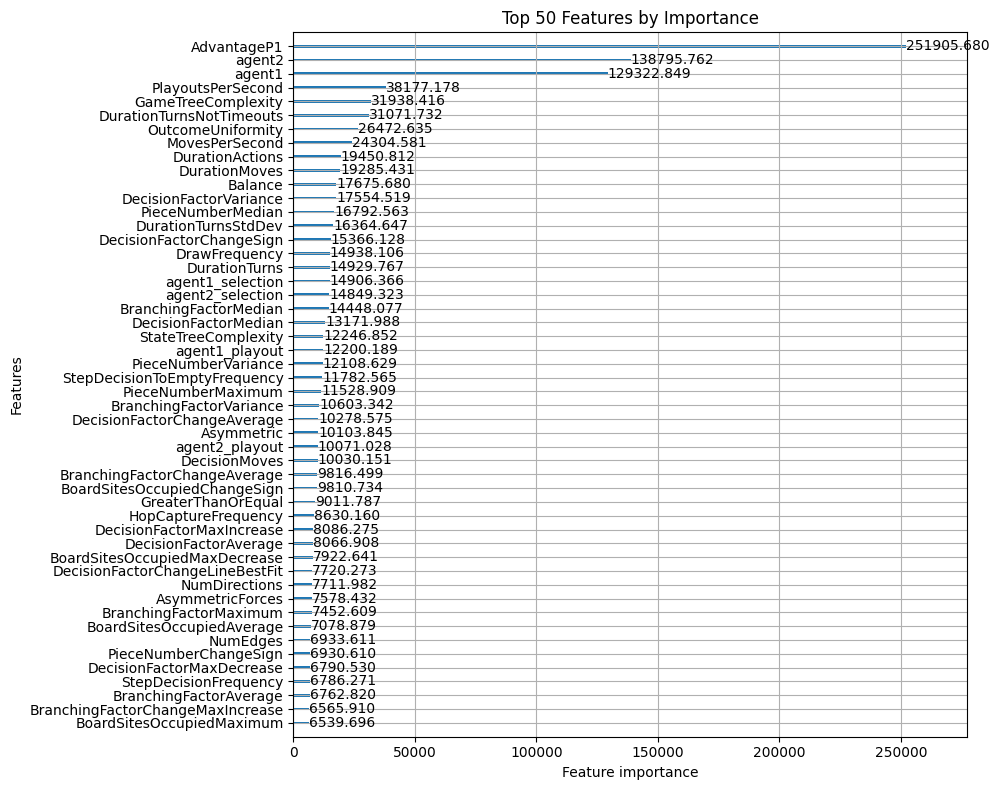

Fold 3 - RMSE: 0.4333830168334574
Fold 4


[100]	valid_0's rmse: 0.528402


[200]	valid_0's rmse: 0.500244


[300]	valid_0's rmse: 0.485927


[400]	valid_0's rmse: 0.478601


[500]	valid_0's rmse: 0.473247


[600]	valid_0's rmse: 0.468656


[700]	valid_0's rmse: 0.46563


[800]	valid_0's rmse: 0.463863


[900]	valid_0's rmse: 0.462509


[1000]	valid_0's rmse: 0.461258


[1100]	valid_0's rmse: 0.459946


[1200]	valid_0's rmse: 0.459101


[1300]	valid_0's rmse: 0.457968


[1400]	valid_0's rmse: 0.457085


[1500]	valid_0's rmse: 0.456279


[1600]	valid_0's rmse: 0.455603


[1700]	valid_0's rmse: 0.454976


[1800]	valid_0's rmse: 0.454224


[1900]	valid_0's rmse: 0.453693


[2000]	valid_0's rmse: 0.453344


[2100]	valid_0's rmse: 0.45295


[2200]	valid_0's rmse: 0.452513


[2300]	valid_0's rmse: 0.452174


[2400]	valid_0's rmse: 0.451898


[2500]	valid_0's rmse: 0.451689


[2600]	valid_0's rmse: 0.451464


[2700]	valid_0's rmse: 0.451233


[2800]	valid_0's rmse: 0.451101


[2900]	valid_0's rmse: 0.450841


[3000]	valid_0's rmse: 0.450617


[3100]	valid_0's rmse: 0.450441


[3200]	valid_0's rmse: 0.450219


[3300]	valid_0's rmse: 0.449994


[3400]	valid_0's rmse: 0.449878


[3500]	valid_0's rmse: 0.4496


[3600]	valid_0's rmse: 0.449367


[3700]	valid_0's rmse: 0.449267


[3800]	valid_0's rmse: 0.44913


[3900]	valid_0's rmse: 0.448869


[4000]	valid_0's rmse: 0.448816


[4100]	valid_0's rmse: 0.448633


[4200]	valid_0's rmse: 0.448332


[4300]	valid_0's rmse: 0.448212


[4400]	valid_0's rmse: 0.448161


[4500]	valid_0's rmse: 0.44804


[4600]	valid_0's rmse: 0.447864


[4700]	valid_0's rmse: 0.447771


[4800]	valid_0's rmse: 0.44764


[4900]	valid_0's rmse: 0.447543


[5000]	valid_0's rmse: 0.447412


[5100]	valid_0's rmse: 0.447353


[5200]	valid_0's rmse: 0.447298


[5300]	valid_0's rmse: 0.44732


[5400]	valid_0's rmse: 0.447275


[5500]	valid_0's rmse: 0.447099


[5600]	valid_0's rmse: 0.447052


[5700]	valid_0's rmse: 0.44698


[5800]	valid_0's rmse: 0.446987


[5900]	valid_0's rmse: 0.446949


[6000]	valid_0's rmse: 0.446899


[6100]	valid_0's rmse: 0.44679


[6200]	valid_0's rmse: 0.446745


[6300]	valid_0's rmse: 0.446646


[6400]	valid_0's rmse: 0.446622


[6500]	valid_0's rmse: 0.446609


[6600]	valid_0's rmse: 0.446555


[6700]	valid_0's rmse: 0.446559


[6800]	valid_0's rmse: 0.446491


[6900]	valid_0's rmse: 0.446416


[7000]	valid_0's rmse: 0.446331


[7100]	valid_0's rmse: 0.44633


[7200]	valid_0's rmse: 0.446286


[7300]	valid_0's rmse: 0.446231


[7400]	valid_0's rmse: 0.446206


[7500]	valid_0's rmse: 0.446196


[7600]	valid_0's rmse: 0.446195


[7700]	valid_0's rmse: 0.44615


[7800]	valid_0's rmse: 0.446128


[7900]	valid_0's rmse: 0.446121


[8000]	valid_0's rmse: 0.446094


[8100]	valid_0's rmse: 0.44604


[8200]	valid_0's rmse: 0.446071


[8300]	valid_0's rmse: 0.445949


[8400]	valid_0's rmse: 0.44589


[8500]	valid_0's rmse: 0.445815


[8600]	valid_0's rmse: 0.44577


[8700]	valid_0's rmse: 0.445802


[8800]	valid_0's rmse: 0.44582


[8900]	valid_0's rmse: 0.445797


[9000]	valid_0's rmse: 0.445811


[9100]	valid_0's rmse: 0.445768


[9200]	valid_0's rmse: 0.44573


[9300]	valid_0's rmse: 0.445651


[9400]	valid_0's rmse: 0.445603


[9500]	valid_0's rmse: 0.445578


[9600]	valid_0's rmse: 0.445571


[9700]	valid_0's rmse: 0.445556


[9800]	valid_0's rmse: 0.445541


[9900]	valid_0's rmse: 0.445536


[10000]	valid_0's rmse: 0.44549


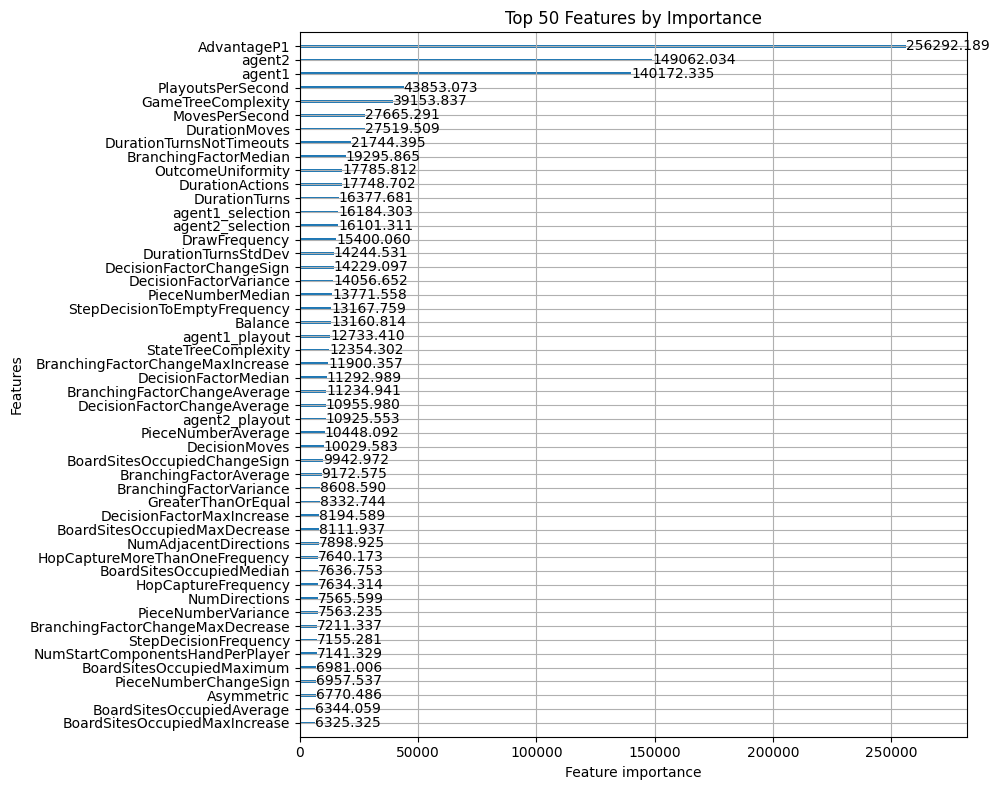

Fold 4 - RMSE: 0.44505094259347233
Fold 5


[100]	valid_0's rmse: 0.521063


[200]	valid_0's rmse: 0.495557


[300]	valid_0's rmse: 0.482291


[400]	valid_0's rmse: 0.473268


[500]	valid_0's rmse: 0.467105


[600]	valid_0's rmse: 0.462579


[700]	valid_0's rmse: 0.458462


[800]	valid_0's rmse: 0.454893


[900]	valid_0's rmse: 0.452379


[1000]	valid_0's rmse: 0.450328


[1100]	valid_0's rmse: 0.4488


[1200]	valid_0's rmse: 0.447432


[1300]	valid_0's rmse: 0.446271


[1400]	valid_0's rmse: 0.445337


[1500]	valid_0's rmse: 0.444491


[1600]	valid_0's rmse: 0.443688


[1700]	valid_0's rmse: 0.442776


[1800]	valid_0's rmse: 0.441962


[1900]	valid_0's rmse: 0.441355


[2000]	valid_0's rmse: 0.44076


[2100]	valid_0's rmse: 0.440179


[2200]	valid_0's rmse: 0.439772


[2300]	valid_0's rmse: 0.439249


[2400]	valid_0's rmse: 0.438695


[2500]	valid_0's rmse: 0.438275


[2600]	valid_0's rmse: 0.437933


[2700]	valid_0's rmse: 0.437631


[2800]	valid_0's rmse: 0.437274


[2900]	valid_0's rmse: 0.436887


[3000]	valid_0's rmse: 0.436639


[3100]	valid_0's rmse: 0.436437


[3200]	valid_0's rmse: 0.436113


[3300]	valid_0's rmse: 0.435861


[3400]	valid_0's rmse: 0.435693


[3500]	valid_0's rmse: 0.435511


[3600]	valid_0's rmse: 0.435318


[3700]	valid_0's rmse: 0.435119


[3800]	valid_0's rmse: 0.434947


[3900]	valid_0's rmse: 0.434724


[4000]	valid_0's rmse: 0.434586


[4100]	valid_0's rmse: 0.434442


[4200]	valid_0's rmse: 0.434288


[4300]	valid_0's rmse: 0.4342


[4400]	valid_0's rmse: 0.434191


[4500]	valid_0's rmse: 0.434043


[4600]	valid_0's rmse: 0.433978


[4700]	valid_0's rmse: 0.433755


[4800]	valid_0's rmse: 0.433682


[4900]	valid_0's rmse: 0.43361


[5000]	valid_0's rmse: 0.433522


[5100]	valid_0's rmse: 0.433403


[5200]	valid_0's rmse: 0.43329


[5300]	valid_0's rmse: 0.433212


[5400]	valid_0's rmse: 0.43316


[5500]	valid_0's rmse: 0.433169


[5600]	valid_0's rmse: 0.4331


[5700]	valid_0's rmse: 0.433031


[5800]	valid_0's rmse: 0.432909


[5900]	valid_0's rmse: 0.432853


[6000]	valid_0's rmse: 0.432842


[6100]	valid_0's rmse: 0.432811


[6200]	valid_0's rmse: 0.432718


[6300]	valid_0's rmse: 0.43275


[6400]	valid_0's rmse: 0.432728


[6500]	valid_0's rmse: 0.432697


[6600]	valid_0's rmse: 0.432662


[6700]	valid_0's rmse: 0.432567


[6800]	valid_0's rmse: 0.432532


[6900]	valid_0's rmse: 0.432375


[7000]	valid_0's rmse: 0.432351


[7100]	valid_0's rmse: 0.43227


[7200]	valid_0's rmse: 0.43225


[7300]	valid_0's rmse: 0.432216


[7400]	valid_0's rmse: 0.432169


[7500]	valid_0's rmse: 0.43213


[7600]	valid_0's rmse: 0.432075


[7700]	valid_0's rmse: 0.432048


[7800]	valid_0's rmse: 0.431992


[7900]	valid_0's rmse: 0.431994


[8000]	valid_0's rmse: 0.43195


[8100]	valid_0's rmse: 0.431917


[8200]	valid_0's rmse: 0.431884


[8300]	valid_0's rmse: 0.431882


[8400]	valid_0's rmse: 0.431776


[8500]	valid_0's rmse: 0.431734


[8600]	valid_0's rmse: 0.431697


[8700]	valid_0's rmse: 0.431653


[8800]	valid_0's rmse: 0.431619


[8900]	valid_0's rmse: 0.431557


[9000]	valid_0's rmse: 0.431566


[9100]	valid_0's rmse: 0.431567


[9200]	valid_0's rmse: 0.431552


[9300]	valid_0's rmse: 0.431484


[9400]	valid_0's rmse: 0.431476


[9500]	valid_0's rmse: 0.43145


[9600]	valid_0's rmse: 0.43148


[9700]	valid_0's rmse: 0.431401


[9800]	valid_0's rmse: 0.431341


[9900]	valid_0's rmse: 0.43138


[10000]	valid_0's rmse: 0.431409


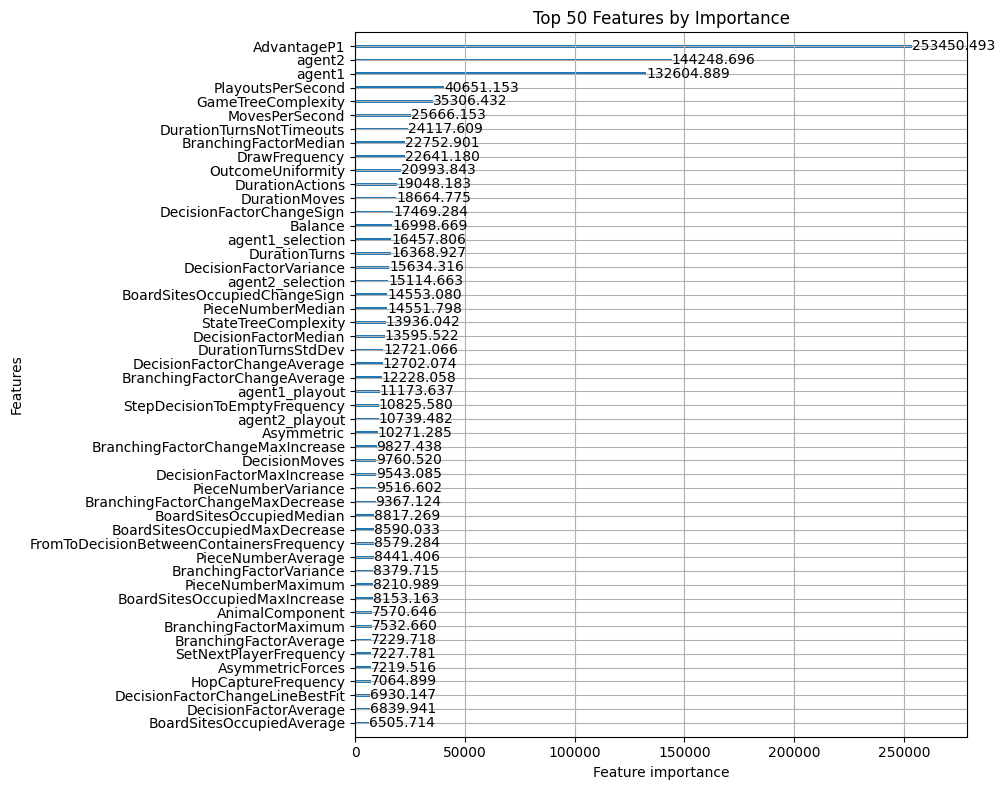

Fold 5 - RMSE: 0.43075931771133075
List of oof scores: [0.4089583230307966, 0.40424631600616534, 0.4333830168334574, 0.44505094259347233, 0.43075931771133075]
Average oof score: 0.42447958323504453


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.509173


[200]	valid_0's rmse: 0.483677


[300]	valid_0's rmse: 0.470968


[400]	valid_0's rmse: 0.463504


[500]	valid_0's rmse: 0.458037


[600]	valid_0's rmse: 0.453883


[700]	valid_0's rmse: 0.450414


[800]	valid_0's rmse: 0.448205


[900]	valid_0's rmse: 0.446157


[1000]	valid_0's rmse: 0.444488


[1100]	valid_0's rmse: 0.443215


[1200]	valid_0's rmse: 0.442022


[1300]	valid_0's rmse: 0.4411


[1400]	valid_0's rmse: 0.440373


[1500]	valid_0's rmse: 0.439712


[1600]	valid_0's rmse: 0.438938


[1700]	valid_0's rmse: 0.438307


[1800]	valid_0's rmse: 0.43777


[1900]	valid_0's rmse: 0.437318


[2000]	valid_0's rmse: 0.436898


[2100]	valid_0's rmse: 0.436481


[2200]	valid_0's rmse: 0.436187


[2300]	valid_0's rmse: 0.435853


[2400]	valid_0's rmse: 0.435426


[2500]	valid_0's rmse: 0.435058


[2600]	valid_0's rmse: 0.434845


[2700]	valid_0's rmse: 0.434597


[2800]	valid_0's rmse: 0.434361


[2900]	valid_0's rmse: 0.434153


[3000]	valid_0's rmse: 0.434084


[3100]	valid_0's rmse: 0.433982


[3200]	valid_0's rmse: 0.433786


[3300]	valid_0's rmse: 0.433573


[3400]	valid_0's rmse: 0.433396


[3500]	valid_0's rmse: 0.433275


[3600]	valid_0's rmse: 0.432985


[3700]	valid_0's rmse: 0.432818


[3800]	valid_0's rmse: 0.432585


[3900]	valid_0's rmse: 0.43241


[4000]	valid_0's rmse: 0.432264


[4100]	valid_0's rmse: 0.432161


[4200]	valid_0's rmse: 0.431991


[4300]	valid_0's rmse: 0.431795


[4400]	valid_0's rmse: 0.431705


[4500]	valid_0's rmse: 0.431631


[4600]	valid_0's rmse: 0.43162


[4700]	valid_0's rmse: 0.431561


[4800]	valid_0's rmse: 0.431479


[4900]	valid_0's rmse: 0.431354


[5000]	valid_0's rmse: 0.431355


[5100]	valid_0's rmse: 0.431267


[5200]	valid_0's rmse: 0.431142


[5300]	valid_0's rmse: 0.431079


[5400]	valid_0's rmse: 0.431007


[5500]	valid_0's rmse: 0.430952


[5600]	valid_0's rmse: 0.430994


[5700]	valid_0's rmse: 0.430962


[5800]	valid_0's rmse: 0.430975


[5900]	valid_0's rmse: 0.430958


[6000]	valid_0's rmse: 0.430844


[6100]	valid_0's rmse: 0.430762


[6200]	valid_0's rmse: 0.430664


[6300]	valid_0's rmse: 0.43065


[6400]	valid_0's rmse: 0.430621


[6500]	valid_0's rmse: 0.430591


[6600]	valid_0's rmse: 0.430487


[6700]	valid_0's rmse: 0.430462


[6800]	valid_0's rmse: 0.430399


[6900]	valid_0's rmse: 0.430377


[7000]	valid_0's rmse: 0.430364


[7100]	valid_0's rmse: 0.430331


[7200]	valid_0's rmse: 0.430235


[7300]	valid_0's rmse: 0.430165


[7400]	valid_0's rmse: 0.430103


[7500]	valid_0's rmse: 0.430107


[7600]	valid_0's rmse: 0.430144


[7700]	valid_0's rmse: 0.430142


[7800]	valid_0's rmse: 0.430107


[7900]	valid_0's rmse: 0.430059


[8000]	valid_0's rmse: 0.430026


[8100]	valid_0's rmse: 0.429994


[8200]	valid_0's rmse: 0.429934


[8300]	valid_0's rmse: 0.429996


[8400]	valid_0's rmse: 0.429951


[8500]	valid_0's rmse: 0.429891


[8600]	valid_0's rmse: 0.429886


[8700]	valid_0's rmse: 0.429843


[8800]	valid_0's rmse: 0.429799


[8900]	valid_0's rmse: 0.429809


[9000]	valid_0's rmse: 0.429841


[9100]	valid_0's rmse: 0.42978


[9200]	valid_0's rmse: 0.429749


[9300]	valid_0's rmse: 0.429704


[9400]	valid_0's rmse: 0.429696


[9500]	valid_0's rmse: 0.429651


[9600]	valid_0's rmse: 0.42963


[9700]	valid_0's rmse: 0.429594


[9800]	valid_0's rmse: 0.429576


[9900]	valid_0's rmse: 0.42957


[10000]	valid_0's rmse: 0.429588


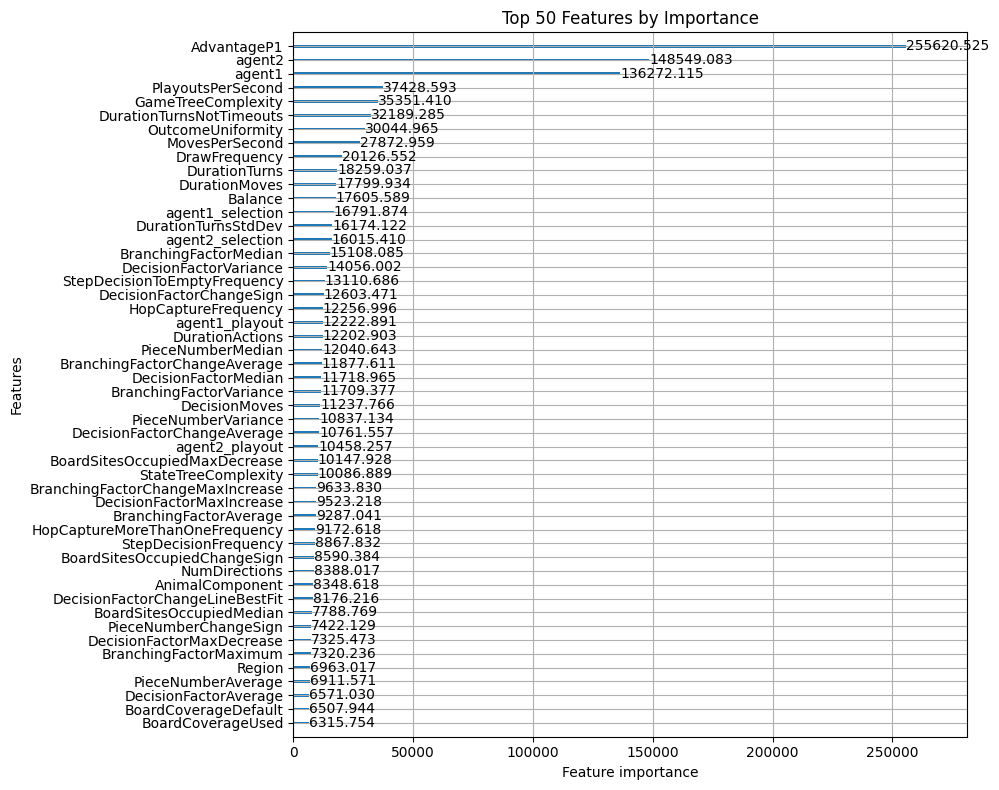

Fold 1 - RMSE: 0.4290307183288908
Fold 2


[100]	valid_0's rmse: 0.507647


[200]	valid_0's rmse: 0.483613


[300]	valid_0's rmse: 0.469297


[400]	valid_0's rmse: 0.459276


[500]	valid_0's rmse: 0.453335


[600]	valid_0's rmse: 0.448596


[700]	valid_0's rmse: 0.444893


[800]	valid_0's rmse: 0.442334


[900]	valid_0's rmse: 0.440107


[1000]	valid_0's rmse: 0.438128


[1100]	valid_0's rmse: 0.436701


[1200]	valid_0's rmse: 0.435258


[1300]	valid_0's rmse: 0.433989


[1400]	valid_0's rmse: 0.432736


[1500]	valid_0's rmse: 0.431595


[1600]	valid_0's rmse: 0.430862


[1700]	valid_0's rmse: 0.430095


[1800]	valid_0's rmse: 0.429407


[1900]	valid_0's rmse: 0.42871


[2000]	valid_0's rmse: 0.428117


[2100]	valid_0's rmse: 0.427586


[2200]	valid_0's rmse: 0.426981


[2300]	valid_0's rmse: 0.426509


[2400]	valid_0's rmse: 0.426005


[2500]	valid_0's rmse: 0.425632


[2600]	valid_0's rmse: 0.425273


[2700]	valid_0's rmse: 0.42495


[2800]	valid_0's rmse: 0.424509


[2900]	valid_0's rmse: 0.424186


[3000]	valid_0's rmse: 0.423918


[3100]	valid_0's rmse: 0.423647


[3200]	valid_0's rmse: 0.423395


[3300]	valid_0's rmse: 0.423195


[3400]	valid_0's rmse: 0.42296


[3500]	valid_0's rmse: 0.42261


[3600]	valid_0's rmse: 0.422357


[3700]	valid_0's rmse: 0.4221


[3800]	valid_0's rmse: 0.421914


[3900]	valid_0's rmse: 0.421677


[4000]	valid_0's rmse: 0.42153


[4100]	valid_0's rmse: 0.421313


[4200]	valid_0's rmse: 0.421121


[4300]	valid_0's rmse: 0.420944


[4400]	valid_0's rmse: 0.420858


[4500]	valid_0's rmse: 0.420756


[4600]	valid_0's rmse: 0.420724


[4700]	valid_0's rmse: 0.420564


[4800]	valid_0's rmse: 0.420432


[4900]	valid_0's rmse: 0.420312


[5000]	valid_0's rmse: 0.420177


[5100]	valid_0's rmse: 0.420096


[5200]	valid_0's rmse: 0.420071


[5300]	valid_0's rmse: 0.420022


[5400]	valid_0's rmse: 0.420002


[5500]	valid_0's rmse: 0.41988


[5600]	valid_0's rmse: 0.41972


[5700]	valid_0's rmse: 0.419612


[5800]	valid_0's rmse: 0.419483


[5900]	valid_0's rmse: 0.419421


[6000]	valid_0's rmse: 0.419315


[6100]	valid_0's rmse: 0.419219


[6200]	valid_0's rmse: 0.419154


[6300]	valid_0's rmse: 0.419147


[6400]	valid_0's rmse: 0.419106


[6500]	valid_0's rmse: 0.419043


[6600]	valid_0's rmse: 0.419044


[6700]	valid_0's rmse: 0.418986


[6800]	valid_0's rmse: 0.418921


[6900]	valid_0's rmse: 0.418924


[7000]	valid_0's rmse: 0.41889


[7100]	valid_0's rmse: 0.418775


[7200]	valid_0's rmse: 0.418737


[7300]	valid_0's rmse: 0.418697


[7400]	valid_0's rmse: 0.41865


[7500]	valid_0's rmse: 0.418587


[7600]	valid_0's rmse: 0.418547


[7700]	valid_0's rmse: 0.418452


[7800]	valid_0's rmse: 0.418413


[7900]	valid_0's rmse: 0.418396


[8000]	valid_0's rmse: 0.418356


[8100]	valid_0's rmse: 0.418375


[8200]	valid_0's rmse: 0.4183


[8300]	valid_0's rmse: 0.418241


[8400]	valid_0's rmse: 0.418227


[8500]	valid_0's rmse: 0.418154


[8600]	valid_0's rmse: 0.418096


[8700]	valid_0's rmse: 0.418017


[8800]	valid_0's rmse: 0.41799


[8900]	valid_0's rmse: 0.41794


[9000]	valid_0's rmse: 0.417931


[9100]	valid_0's rmse: 0.417904


[9200]	valid_0's rmse: 0.417894


[9300]	valid_0's rmse: 0.417854


[9400]	valid_0's rmse: 0.41784


[9500]	valid_0's rmse: 0.417825


[9600]	valid_0's rmse: 0.41775


[9700]	valid_0's rmse: 0.417703


[9800]	valid_0's rmse: 0.417678


[9900]	valid_0's rmse: 0.417668


[10000]	valid_0's rmse: 0.417616


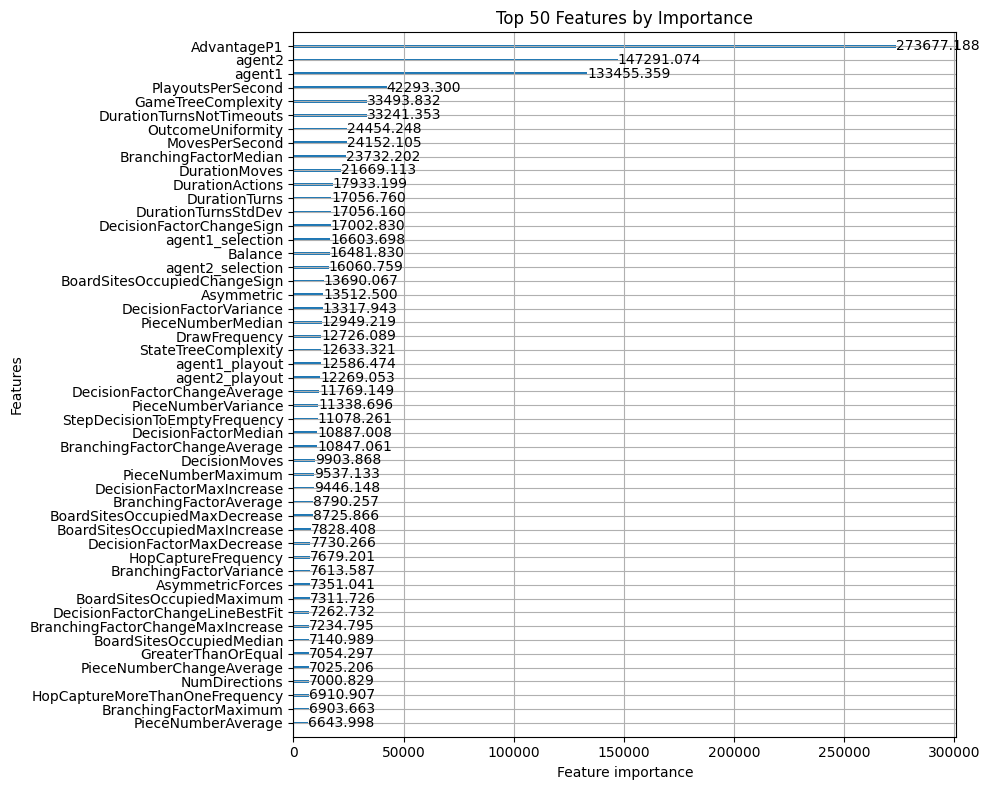

Fold 2 - RMSE: 0.41718550111504454
Fold 3


[100]	valid_0's rmse: 0.499761


[200]	valid_0's rmse: 0.473964


[300]	valid_0's rmse: 0.46286


[400]	valid_0's rmse: 0.455304


[500]	valid_0's rmse: 0.450686


[600]	valid_0's rmse: 0.447425


[700]	valid_0's rmse: 0.44475


[800]	valid_0's rmse: 0.442396


[900]	valid_0's rmse: 0.440359


[1000]	valid_0's rmse: 0.438837


[1100]	valid_0's rmse: 0.437574


[1200]	valid_0's rmse: 0.436261


[1300]	valid_0's rmse: 0.435168


[1400]	valid_0's rmse: 0.434415


[1500]	valid_0's rmse: 0.433785


[1600]	valid_0's rmse: 0.433157


[1700]	valid_0's rmse: 0.432591


[1800]	valid_0's rmse: 0.432015


[1900]	valid_0's rmse: 0.431466


[2000]	valid_0's rmse: 0.43102


[2100]	valid_0's rmse: 0.430579


[2200]	valid_0's rmse: 0.430216


[2300]	valid_0's rmse: 0.429849


[2400]	valid_0's rmse: 0.42956


[2500]	valid_0's rmse: 0.42923


[2600]	valid_0's rmse: 0.428821


[2700]	valid_0's rmse: 0.42867


[2800]	valid_0's rmse: 0.428411


[2900]	valid_0's rmse: 0.428214


[3000]	valid_0's rmse: 0.428028


[3100]	valid_0's rmse: 0.427813


[3200]	valid_0's rmse: 0.427603


[3300]	valid_0's rmse: 0.427395


[3400]	valid_0's rmse: 0.427196


[3500]	valid_0's rmse: 0.42706


[3600]	valid_0's rmse: 0.426964


[3700]	valid_0's rmse: 0.42675


[3800]	valid_0's rmse: 0.426643


[3900]	valid_0's rmse: 0.426475


[4000]	valid_0's rmse: 0.426236


[4100]	valid_0's rmse: 0.426145


[4200]	valid_0's rmse: 0.426014


[4300]	valid_0's rmse: 0.425854


[4400]	valid_0's rmse: 0.425778


[4500]	valid_0's rmse: 0.425704


[4600]	valid_0's rmse: 0.425653


[4700]	valid_0's rmse: 0.425566


[4800]	valid_0's rmse: 0.425516


[4900]	valid_0's rmse: 0.42541


[5000]	valid_0's rmse: 0.425297


[5100]	valid_0's rmse: 0.425321


[5200]	valid_0's rmse: 0.425163


[5300]	valid_0's rmse: 0.425053


[5400]	valid_0's rmse: 0.424935


[5500]	valid_0's rmse: 0.424855


[5600]	valid_0's rmse: 0.424825


[5700]	valid_0's rmse: 0.424741


[5800]	valid_0's rmse: 0.424677


[5900]	valid_0's rmse: 0.424575


[6000]	valid_0's rmse: 0.424601


[6100]	valid_0's rmse: 0.424559


[6200]	valid_0's rmse: 0.42449


[6300]	valid_0's rmse: 0.424407


[6400]	valid_0's rmse: 0.424361


[6500]	valid_0's rmse: 0.424324


[6600]	valid_0's rmse: 0.424266


[6700]	valid_0's rmse: 0.424231


[6800]	valid_0's rmse: 0.424253


[6900]	valid_0's rmse: 0.424183


[7000]	valid_0's rmse: 0.424098


[7100]	valid_0's rmse: 0.424051


[7200]	valid_0's rmse: 0.424003


[7300]	valid_0's rmse: 0.424012


[7400]	valid_0's rmse: 0.423969


[7500]	valid_0's rmse: 0.423982


[7600]	valid_0's rmse: 0.423954


[7700]	valid_0's rmse: 0.423936


[7800]	valid_0's rmse: 0.423831


[7900]	valid_0's rmse: 0.423784


[8000]	valid_0's rmse: 0.423718


[8100]	valid_0's rmse: 0.42369


[8200]	valid_0's rmse: 0.423707


[8300]	valid_0's rmse: 0.423698


[8400]	valid_0's rmse: 0.42367


[8500]	valid_0's rmse: 0.423685


[8600]	valid_0's rmse: 0.42367


[8700]	valid_0's rmse: 0.423656


[8800]	valid_0's rmse: 0.423642


[8900]	valid_0's rmse: 0.423646


[9000]	valid_0's rmse: 0.423647


[9100]	valid_0's rmse: 0.423664


[9200]	valid_0's rmse: 0.423629


[9300]	valid_0's rmse: 0.423614


[9400]	valid_0's rmse: 0.423571


[9500]	valid_0's rmse: 0.423549


[9600]	valid_0's rmse: 0.423534


[9700]	valid_0's rmse: 0.423519


[9800]	valid_0's rmse: 0.423434


[9900]	valid_0's rmse: 0.423482


[10000]	valid_0's rmse: 0.423497


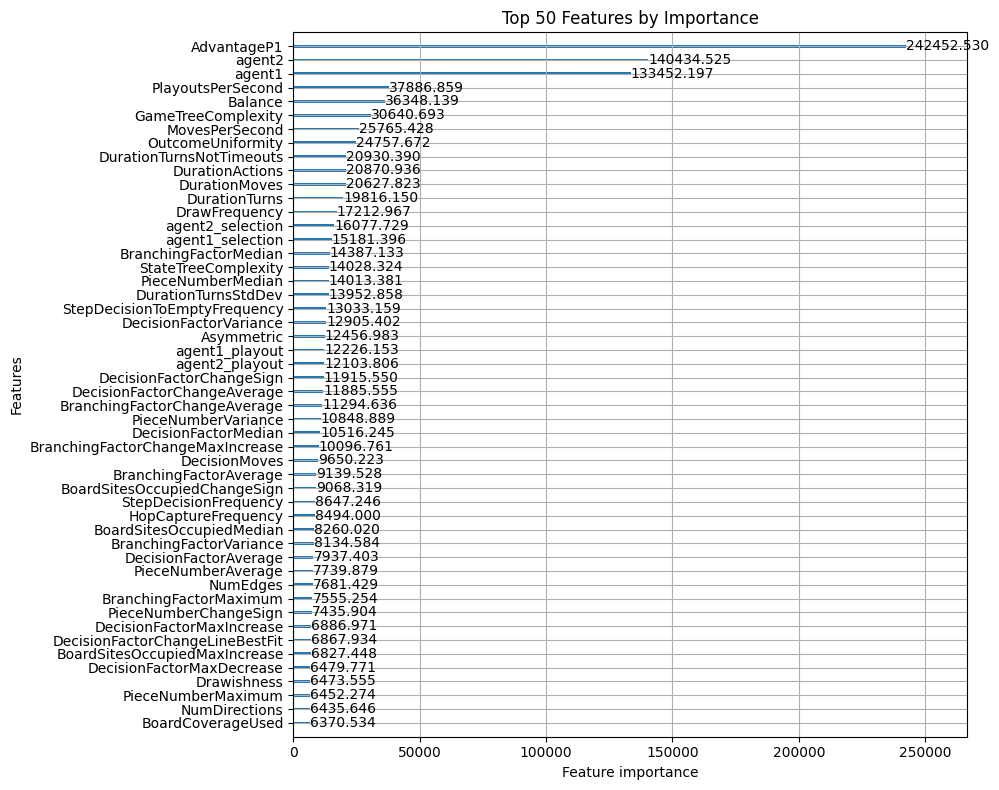

Fold 3 - RMSE: 0.42293011128787694
Fold 4


[100]	valid_0's rmse: 0.493108


[200]	valid_0's rmse: 0.467939


[300]	valid_0's rmse: 0.457443


[400]	valid_0's rmse: 0.44987


[500]	valid_0's rmse: 0.445356


[600]	valid_0's rmse: 0.441549


[700]	valid_0's rmse: 0.438912


[800]	valid_0's rmse: 0.437089


[900]	valid_0's rmse: 0.435397


[1000]	valid_0's rmse: 0.433662


[1100]	valid_0's rmse: 0.43228


[1200]	valid_0's rmse: 0.431169


[1300]	valid_0's rmse: 0.430245


[1400]	valid_0's rmse: 0.429247


[1500]	valid_0's rmse: 0.428703


[1600]	valid_0's rmse: 0.428146


[1700]	valid_0's rmse: 0.427537


[1800]	valid_0's rmse: 0.42709


[1900]	valid_0's rmse: 0.426491


[2000]	valid_0's rmse: 0.426068


[2100]	valid_0's rmse: 0.425603


[2200]	valid_0's rmse: 0.425366


[2300]	valid_0's rmse: 0.425023


[2400]	valid_0's rmse: 0.424757


[2500]	valid_0's rmse: 0.424471


[2600]	valid_0's rmse: 0.42417


[2700]	valid_0's rmse: 0.42397


[2800]	valid_0's rmse: 0.423761


[2900]	valid_0's rmse: 0.423456


[3000]	valid_0's rmse: 0.423248


[3100]	valid_0's rmse: 0.423127


[3200]	valid_0's rmse: 0.423001


[3300]	valid_0's rmse: 0.422829


[3400]	valid_0's rmse: 0.422594


[3500]	valid_0's rmse: 0.422436


[3600]	valid_0's rmse: 0.422399


[3700]	valid_0's rmse: 0.422292


[3800]	valid_0's rmse: 0.422237


[3900]	valid_0's rmse: 0.42218


[4000]	valid_0's rmse: 0.422117


[4100]	valid_0's rmse: 0.422052


[4200]	valid_0's rmse: 0.421976


[4300]	valid_0's rmse: 0.421909


[4400]	valid_0's rmse: 0.421749


[4500]	valid_0's rmse: 0.421744


[4600]	valid_0's rmse: 0.42165


[4700]	valid_0's rmse: 0.42158


[4800]	valid_0's rmse: 0.421533


[4900]	valid_0's rmse: 0.421481


[5000]	valid_0's rmse: 0.421423


[5100]	valid_0's rmse: 0.42134


[5200]	valid_0's rmse: 0.421246


[5300]	valid_0's rmse: 0.421158


[5400]	valid_0's rmse: 0.421112


[5500]	valid_0's rmse: 0.421069


[5600]	valid_0's rmse: 0.420987


[5700]	valid_0's rmse: 0.420896


[5800]	valid_0's rmse: 0.42088


[5900]	valid_0's rmse: 0.420796


[6000]	valid_0's rmse: 0.420697


[6100]	valid_0's rmse: 0.420648


[6200]	valid_0's rmse: 0.420602


[6300]	valid_0's rmse: 0.420559


[6400]	valid_0's rmse: 0.420508


[6500]	valid_0's rmse: 0.420465


[6600]	valid_0's rmse: 0.420445


[6700]	valid_0's rmse: 0.420362


[6800]	valid_0's rmse: 0.420298


[6900]	valid_0's rmse: 0.420269


[7000]	valid_0's rmse: 0.420192


[7100]	valid_0's rmse: 0.420085


[7200]	valid_0's rmse: 0.420014


[7300]	valid_0's rmse: 0.420028


[7400]	valid_0's rmse: 0.41999


[7500]	valid_0's rmse: 0.419977


[7600]	valid_0's rmse: 0.419916


[7700]	valid_0's rmse: 0.419846


[7800]	valid_0's rmse: 0.419933


[7900]	valid_0's rmse: 0.419913


[8000]	valid_0's rmse: 0.419864


[8100]	valid_0's rmse: 0.419811


[8200]	valid_0's rmse: 0.419819


[8300]	valid_0's rmse: 0.419773


[8400]	valid_0's rmse: 0.419798


[8500]	valid_0's rmse: 0.419789


[8600]	valid_0's rmse: 0.419811


[8700]	valid_0's rmse: 0.419797


[8800]	valid_0's rmse: 0.419851


[8900]	valid_0's rmse: 0.419817


[9000]	valid_0's rmse: 0.419862


[9100]	valid_0's rmse: 0.419827


[9200]	valid_0's rmse: 0.419795


[9300]	valid_0's rmse: 0.419776


[9400]	valid_0's rmse: 0.419752


[9500]	valid_0's rmse: 0.41975


[9600]	valid_0's rmse: 0.419724


[9700]	valid_0's rmse: 0.419701


[9800]	valid_0's rmse: 0.419692


[9900]	valid_0's rmse: 0.41969


[10000]	valid_0's rmse: 0.419693


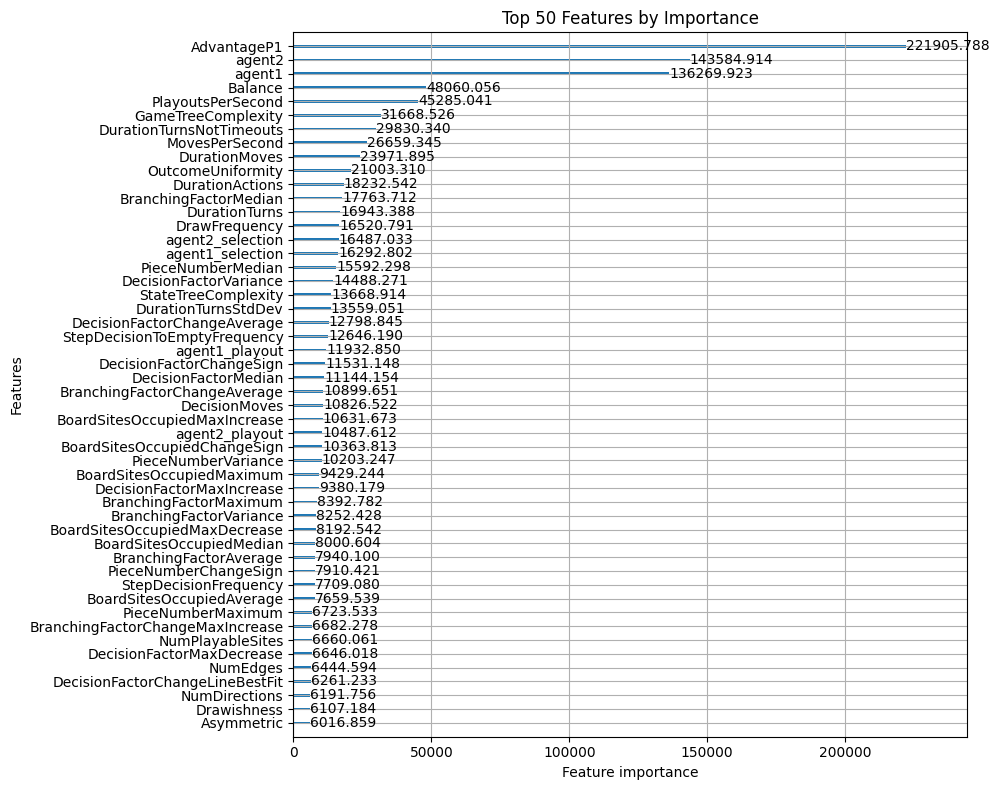

Fold 4 - RMSE: 0.4188948305211014
Fold 5


[100]	valid_0's rmse: 0.511949


[200]	valid_0's rmse: 0.489309


[300]	valid_0's rmse: 0.477508


[400]	valid_0's rmse: 0.469886


[500]	valid_0's rmse: 0.463969


[600]	valid_0's rmse: 0.458647


[700]	valid_0's rmse: 0.455035


[800]	valid_0's rmse: 0.45162


[900]	valid_0's rmse: 0.449261


[1000]	valid_0's rmse: 0.44704


[1100]	valid_0's rmse: 0.44533


[1200]	valid_0's rmse: 0.443763


[1300]	valid_0's rmse: 0.442532


[1400]	valid_0's rmse: 0.44126


[1500]	valid_0's rmse: 0.440253


[1600]	valid_0's rmse: 0.439426


[1700]	valid_0's rmse: 0.438553


[1800]	valid_0's rmse: 0.437933


[1900]	valid_0's rmse: 0.437317


[2000]	valid_0's rmse: 0.436814


[2100]	valid_0's rmse: 0.436223


[2200]	valid_0's rmse: 0.435696


[2300]	valid_0's rmse: 0.434989


[2400]	valid_0's rmse: 0.434538


[2500]	valid_0's rmse: 0.43399


[2600]	valid_0's rmse: 0.433638


[2700]	valid_0's rmse: 0.433219


[2800]	valid_0's rmse: 0.433003


[2900]	valid_0's rmse: 0.432747


[3000]	valid_0's rmse: 0.432434


[3100]	valid_0's rmse: 0.432106


[3200]	valid_0's rmse: 0.431838


[3300]	valid_0's rmse: 0.431552


[3400]	valid_0's rmse: 0.431473


[3500]	valid_0's rmse: 0.431215


[3600]	valid_0's rmse: 0.430991


[3700]	valid_0's rmse: 0.430805


[3800]	valid_0's rmse: 0.430539


[3900]	valid_0's rmse: 0.430345


[4000]	valid_0's rmse: 0.430163


[4100]	valid_0's rmse: 0.430052


[4200]	valid_0's rmse: 0.429852


[4300]	valid_0's rmse: 0.429599


[4400]	valid_0's rmse: 0.429391


[4500]	valid_0's rmse: 0.429222


[4600]	valid_0's rmse: 0.429048


[4700]	valid_0's rmse: 0.428859


[4800]	valid_0's rmse: 0.428737


[4900]	valid_0's rmse: 0.428641


[5000]	valid_0's rmse: 0.428513


[5100]	valid_0's rmse: 0.42847


[5200]	valid_0's rmse: 0.42839


[5300]	valid_0's rmse: 0.428277


[5400]	valid_0's rmse: 0.428182


[5500]	valid_0's rmse: 0.428116


[5600]	valid_0's rmse: 0.428031


[5700]	valid_0's rmse: 0.427937


[5800]	valid_0's rmse: 0.427752


[5900]	valid_0's rmse: 0.427629


[6000]	valid_0's rmse: 0.427568


[6100]	valid_0's rmse: 0.427557


[6200]	valid_0's rmse: 0.427422


[6300]	valid_0's rmse: 0.427415


[6400]	valid_0's rmse: 0.427422


[6500]	valid_0's rmse: 0.427403


[6600]	valid_0's rmse: 0.427412


[6700]	valid_0's rmse: 0.427397


[6800]	valid_0's rmse: 0.427396


[6900]	valid_0's rmse: 0.427319


[7000]	valid_0's rmse: 0.427287


[7100]	valid_0's rmse: 0.427306


[7200]	valid_0's rmse: 0.427226


[7300]	valid_0's rmse: 0.42712


[7400]	valid_0's rmse: 0.427129


[7500]	valid_0's rmse: 0.427088


[7600]	valid_0's rmse: 0.427085


[7700]	valid_0's rmse: 0.427064


[7800]	valid_0's rmse: 0.426974


[7900]	valid_0's rmse: 0.426928


[8000]	valid_0's rmse: 0.426912


[8100]	valid_0's rmse: 0.426858


[8200]	valid_0's rmse: 0.426855


[8300]	valid_0's rmse: 0.426835


[8400]	valid_0's rmse: 0.426893


[8500]	valid_0's rmse: 0.42679


[8600]	valid_0's rmse: 0.426781


[8700]	valid_0's rmse: 0.426736


[8800]	valid_0's rmse: 0.426733


[8900]	valid_0's rmse: 0.42669


[9000]	valid_0's rmse: 0.426582


[9100]	valid_0's rmse: 0.426547


[9200]	valid_0's rmse: 0.426557


[9300]	valid_0's rmse: 0.426537


[9400]	valid_0's rmse: 0.426561


[9500]	valid_0's rmse: 0.426601


[9600]	valid_0's rmse: 0.426587


[9700]	valid_0's rmse: 0.426609


[9800]	valid_0's rmse: 0.426626


[9900]	valid_0's rmse: 0.426593


[10000]	valid_0's rmse: 0.426576


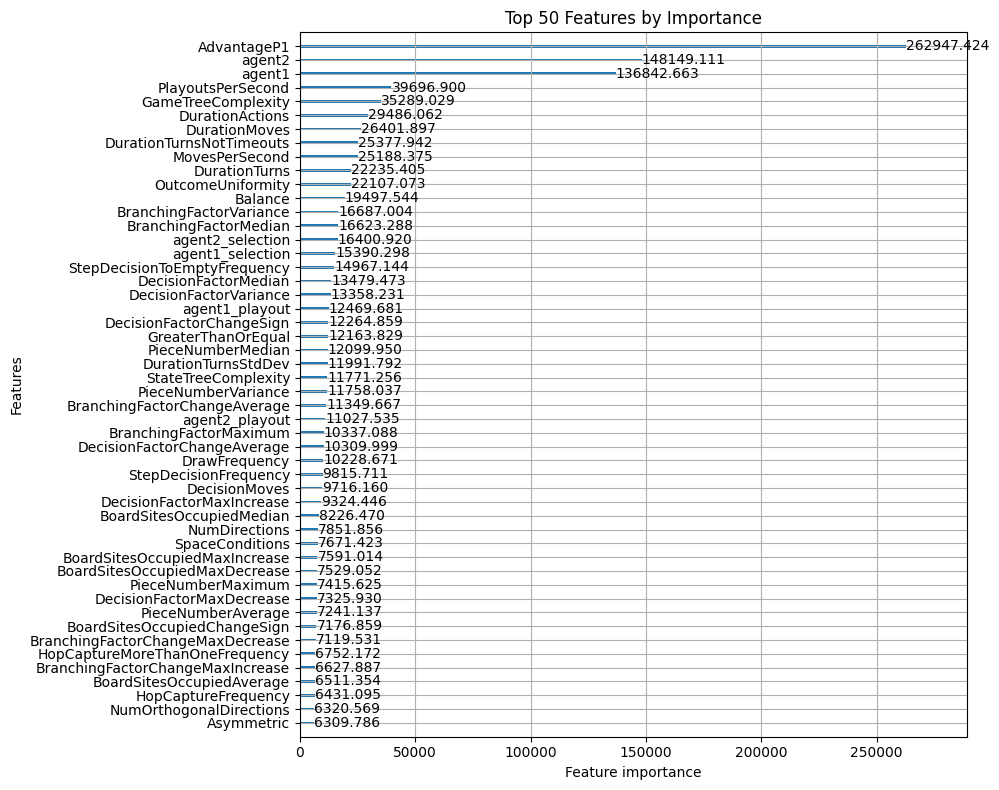

Fold 5 - RMSE: 0.4260299782715409
List of oof scores: [0.4290307183288908, 0.41718550111504454, 0.42293011128787694, 0.4188948305211014, 0.4260299782715409]
Average oof score: 0.42281422790489087


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4263
Score: 0.4475
Score: 0.4355
Score: 0.4336
Score: 0.4045
Average CV1 Score: 0.4295

CV2 OOF Scores:
Score: 0.4090
Score: 0.4042
Score: 0.4334
Score: 0.4451
Score: 0.4308
Average CV2 Score: 0.4245

CV3 OOF Scores:
Score: 0.4290
Score: 0.4172
Score: 0.4229
Score: 0.4189
Score: 0.4260
Average CV3 Score: 0.4228


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

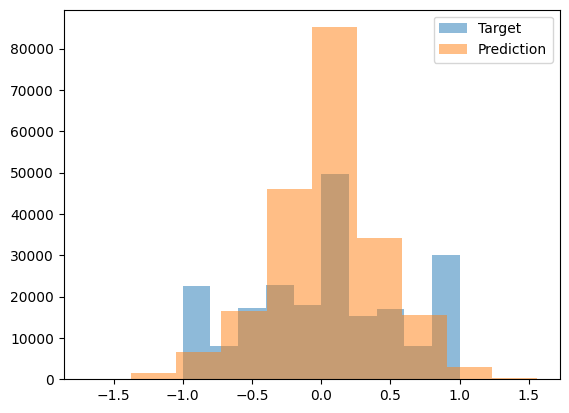

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.139881       │
│ 233235 ┆ -0.1926        │
│ 233236 ┆ -0.025289      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***